In [3]:
import pandas as pd
import numpy as np
import random as rd
import datetime as dt
import matplotlib.finance as fin
import matplotlib.pyplot as plt
import sys
import pyodbc as pyodbc
import time

sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')

import myfunctions as myf
import qadconnect34 as q
from stoxx.dates import keydates as kd

creds = 'DRIVER={SQL Server};SERVER=mpzhwindex01;DATABASE=qai;UID=stx-ro;PWD=stx-ro'
con = pyodbc.connect(creds)

%pylab inline

bojloc ='G:/stoxx/STOXX/Product Development & Research/Projects/2134 iSTOXX Bank of Japan BoJ Capex/'
histloc = bojloc + '03 History/'
calcloc = histloc + '01 calc steps/'

Populating the interactive namespace from numpy and matplotlib


In [128]:
#use IF compositions
cut_dates = ['2010-08-02','2012-03-13'] #launch dates are '2011-02-21','2012-04-16', but these here are the cut dates for production available data

fs = ['IF_STXJPTM_EUR_Price.csv','IF_STXJP600_EUR_Price.csv']
ct=0
for f in fs:
    dfjp = pd.read_csv(histloc + f, sep=';', 
                   usecols=['Date','ISIN','SEDOL','Currency','ICB Subsector','F/X rate','Freefloat Market Cap'],
                      dtype={'SEDOL': object, 'ICB Subsector': object, 'Freefloat Market Cap': float}).sort('Date', ascending=True)
    dfjp['name'] = ''
    dfjp['symbol'] = ''
    dfjp['dt'] = pd.to_datetime(dfjp['Date'], format='%Y-%m-%d', dayfirst=True)

    dfjp = dfjp[dfjp['Date'] < cut_dates[ct]].reset_index(drop=True) ##### only for last rebalancing
    
    dfjp = dfjp.rename(columns={'Date':'date', 'ISIN':'isin', 'SEDOL':'sedol', 'Currency':'curr', 'ICB Subsector': 'icb',
                                'F/X rate':'fx', 'Freefloat Market Cap': 'ffmcap_eur'})
    
    #updating missing sedols - need sedols to get Worldscope data
    dfjp.loc[dfjp['isin']=='JP3480400005','sedol']='6569668' #update sedol for Cedyna Financial - delisted comp
    for index, row in dfjp[dfjp.sedol.isnull()].iterrows(): #update rest using QAD sedols
        if not isnan(q.get_infocode(row['isin'])):
            dfjp.loc[index,'sedol']=q.get_sedol(q.get_infocode(row['isin']))
    if ct==0:
        dfjp.to_csv(calcloc + '01_STXJPTMI_Base_4Q.csv',sep=';',index=False)
        dfy = dfjp
    else:
        dfjp = dfjp[dfjp['dt'].map(lambda x: x.month==6 or x.month==12)]
        dfjp.to_csv(calcloc + '01_STXJP600_Base.csv',sep=';',index=False)
        dfz = dfjp
    ct=ct+1
    
    print('done')

done
done


In [126]:
dfjp.head()

,date,isin,curr,fx,sedol,icb,ffmcap_eur,ffmcap_jpy,name_,symbol,...,ICB_sec,ICB_ind_name,ROE,final_score,rkFinal,wgt,cap,capfactor,cappedwgt,cusip
0,2008-06-23,JP3633400001,JPY,0.005983,6900643,3353,1.111303e+11,1.857291e+13,TOYOTA MOTOR CORPORATION,NaN,...,3350,Consumer Goods,0.144730,0.5806202,187,0.093728,0.02,0.170814,0.02,NaN
1,2008-06-23,JP3756600007,JPY,0.005983,6639550,3747,4.988049e+10,8.336389e+12,"Nintendo Co.,Ltd.",NaN,...,3740,Consumer Goods,0.209242,0.7544326,28,0.042069,0.02,0.380562,0.02,NaN
2,2008-06-23,JP3242800005,JPY,0.005983,6172323,9574,4.346034e+10,7.263407e+12,Canon Inc.,NaN,...,9570,Technology,0.162896,0.8558457,1,0.036655,0.02,0.436780,0.02,NaN
3,2008-06-23,JP3165650007,JPY,0.005983,6129277,6575,4.116662e+10,6.880064e+12,"NTT DoCoMo,Inc.",NaN,...,6570,Telecommunications,0.114861,0.6144481,161,0.034720,0.02,0.461117,0.02,NaN
4,2008-06-23,JP3854600008,JPY,0.005983,6435145,3353,4.011714e+10,6.704667e+12,"HONDA MOTOR CO.,LTD.",NaN,...,3350,Consumer Goods,0.132043,0.7561196,26,0.033835,0.02,0.473180,0.02,NaN


In [129]:
#get the composition from production
cut_dates = ['2012-03-13', '2010-08-02'] #launch dates are '2011-02-21','2012-04-16'

rev_qs = [[6,12], [3,6,9,12]]
idxs = ['sx60jp', 'tw1p'] #tcjpp: japan TMI; use tw1p instead;  sx60jp: japan 600
#idxs = ['sx60jp', 'xx']

rdts = kd.reviewdates()

locdata = 'Y:/STOXX/'
dffoo = pd.DataFrame()
ct=0
for idx in idxs:
    #print(idx, rev_qs[ct],cut_dates[ct])
    rd = rdts[rdts.mth.isin(rev_qs[ct]) & (rdts.effdt > cut_dates[ct])]['effdt']
    dfdts = pd.DataFrame(rd)
    
    dffoo = pd.DataFrame()
    
    for index, row in dfdts.iterrows():
        dt = str((row[dfdts.columns[0]]).replace('-',''))
        of = '/open_' + idx + '_' + dt + '.csv'
        
        try:    
            dffo = pd.read_csv(locdata + idx + of, encoding='utf-8-sig', sep=';', dtype={'ICB': object, 'Internal_Number': object})
            #print(1, dt, idx, len(dffo.columns))
        except:
            try:
                dffo = pd.read_csv(locdata + idx + of, encoding='iso-8859-1', sep=';', dtype={'ICB': object, 'Internal_Number': object})
                #print(2, dt, idx)
            except:
                pass
            
        if len(dffo.columns)==37:
            del dffo['RIC']
            del dffo[dffo.columns[len(dffo.columns)-1]]
            df1 = dffo[[0,11,16,26,12,18,28,14,10]]

        if len(dffo.columns)==36:
            del dffo['RIC']
            cols = dffo.columns
            dffo.insert(0, 'x', dffo.index)
            del dffo[dffo.columns[len(dffo.columns)-1]]
            dffo.columns = cols
            df1 = dffo[[0,11,16,26,12,18,28,14,10]] 
   
        df1 = df1.rename(columns={'Next_Trading_Day':'date', 'ISIN':'isin', 'SEDOL':'sedol', 'Currency':'curr', 
                                'FX_local_to_Index_Currency':'fx', 'ICB': 'icb', 'Mcap_Units_Index_Currency': 'ffmcap_eur',
                                'Instrument_Name': 'name', 'Internal_Number':'symbol'})
        
        df1['dt']=pd.to_datetime(df1['date'], format='%Y-%m-%d', dayfirst=True)
        
        dffoo = pd.concat([dffoo, df1], axis=0)
        #print(len(dffo.columns))
        
    dffoo.to_csv(calcloc + '01_' + idx + '_prod.csv', index=False, sep=';')
    #dffoo['dt'] = pd.to_datetime(dffoo['Next_Trading_Day'], format='%Y-%m-%d', dayfirst=True)
    
    ct = ct + 1

print('done')

done


In [4]:
#get icb mapping and full files
dfind = pd.read_excel(histloc + 'industry_codes1.xlsx', sheetname='full')
dfind['old_subs'] = dfind['old_subs'].astype(int)

dfjp1 = pd.read_csv(calcloc + '01_STXJP600_Base.csv', sep=';')
dfjp2 = pd.read_csv(calcloc + '01_sx60jp_prod.csv', sep=';', dtype={'symbol': object})

dfjp = pd.concat([dfjp1, dfjp2], axis=0).sort(['date', 'ffmcap_eur'], ascending=[True, False])
dfjp.loc[dfjp['isin']=='JP3463200000', 'icb'] = 8773 #missing ICB in database
dfjp = pd.merge(dfjp, dfind, how='left', left_on='icb', right_on='old_subs')

del dfjp['old_subs']
dfjp.to_csv(calcloc + '02_jp600.csv',sep=';',index=False)

dfjp3 = pd.read_csv(calcloc + '01_STXJPTMI_Base_4Q.csv', sep=';')
dfjp4 = pd.read_csv(calcloc + '01_tw1p_prod.csv', sep=';', encoding='iso-8859-1', dtype={'symbol': object})
dfjp0 = pd.concat([dfjp3, dfjp4], axis=0).sort(['date', 'ffmcap_eur'], ascending=[True, False])
dfjp0.loc[dfjp0['isin']=='JP3463200000', 'icb'] = 8773 #missing ICB in database
dfjp0 = pd.merge(dfjp0, dfind, how='left', left_on='icb', right_on='old_subs')
del dfjp0['old_subs']
dfjp0.to_csv(calcloc + '02_jptmi.csv',sep=';',index=False)

print('done')

done


In [45]:
#review June
dfjune = pd.read_excel(calcloc + 'june2016/' + 'qr_sx60jp_20160610.xls')
dfstxjune = pd.read_csv(calcloc + 'june2016/' + 'stoxx_global.txt', sep=';')
dfjune = dfjune[-dfjune['New Flag'].isnull()].reset_index(drop=True)[[0,1,3,4,6,7]]
dfjune.columns = ['isin','sedol','symbol','name','curr','icb']
dfstxjune=dfstxjune[[3,12,13,17]]
dfstxjune['mcap_eur'] = dfstxjune['Shares']*dfstxjune['free-float']*dfstxjune['close_eur']
dfstxjune = dfstxjune[[0,4]]
dfstxjune.columns = ['symbol','ffmcap_eur']
dfstxjune['symbol'] = dfstxjune['symbol'].map(lambda x: x.strip())
dfjune = pd.merge(dfjune, dfstxjune, how='left', on='symbol')
#dfjune.to_csv(calcloc + 'june2016/' + 'june.csv', sep=';', index=False)
dfjune.head()
dfjune['date'] = '2016-06-20'
dfjune['dt'] = pd.to_datetime(dfjune['date'], format='%Y-%m-%d', dayfirst=True)
dfjune['fx'] = np.nan
dfjune = dfjune[[7,0,4,9,1,5,6,3,2,8]]

#get icb mapping and full files
dfind = pd.read_excel(histloc + 'industry_codes1.xlsx', sheetname='full')
dfind['old_subs'] = dfind['old_subs'].astype(int)

#dfjp.loc[dfjp['isin']=='JP3463200000', 'icb'] = 8773 #missing ICB in database
dfjune = pd.merge(dfjune, dfind, how='left', left_on='icb', right_on='old_subs')

del dfjune['old_subs']
dfjune.to_csv(calcloc + 'june2016/' + '02_jp600_.csv',sep=';',index=False)

dfjune.head(2)

,date,isin,curr,fx,sedol,icb,ffmcap_eur,name,symbol,dt,ICB_ind,ICB_sec,ICB_ind_name
0,2016-06-20,JP3633400001,JPY,NaN,6900643,3353,1.351197e+11,Toyota Motor Corp.,690064,2016-06-20,3000,3350,Consumer Goods
1,2016-06-20,JP3902900004,JPY,NaN,6335171,8355,6.355365e+10,Mitsubishi UFJ Financial Group,659668,2016-06-20,8000,8350,Financials


In [46]:
#get all infocodes
#df = pd.read_csv(calcloc +'02_jp600.csv', sep=';', dtype={'symbol': object})
df = pd.read_csv(calcloc + 'june2016/' + '02_jp600_.csv', sep=';', dtype={'symbol': object})
df = df.sort(['dt', 'isin'], ascending=[True, True]).reset_index(drop=True)
df['dt2']=pd.to_datetime(df['date'], format='%Y-%m-%d', dayfirst=True)

dfds = pd.read_excel(histloc + 'DSCODE_map.xlsx')

dto = np.datetime64('2050-01-01')
dfds['dtto'] = dfds['dtto'].fillna(dto)

df = df.iloc[:,:]

infocode_list = []
dfids = df[['sedol','isin']].drop_duplicates().reset_index(drop=True)
print(len(dfids))
for index, row in dfids.iterrows():
    if np.isnan(q.get_infocode(row.sedol)):
        infocode = q.get_infocode(dfids.loc[index,'isin'])
    else:
        infocode = q.get_infocode(row.sedol)
        
    infocode_list.append(infocode)
    if not (index+1) % 200:
        print(index+1)
        
dfids['infocode'] = infocode_list
df = pd.merge(df, dfids, how='left', on=['sedol','isin']).drop_duplicates()
# -----------

# get infocode from DSCODE_map 
for index, row in dfds.iterrows():
    df.loc[df[(df.symbol==row.symbol) & (df.dt2>=row.dtfrom) & (df.dt2<=row.dtto)].index, 'infocode'] = row.infocode
# -----------

del df['dt2']

#df.to_csv(calcloc + '02_jp600_info.csv', sep=';', index=False)
df.to_csv(calcloc + 'june2016/' +  '02_jp600_info_.csv', sep=';', index=False)

print('done')

600
200
400
600
done


(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.]),
 <a list of 7 Text xticklabel objects>)

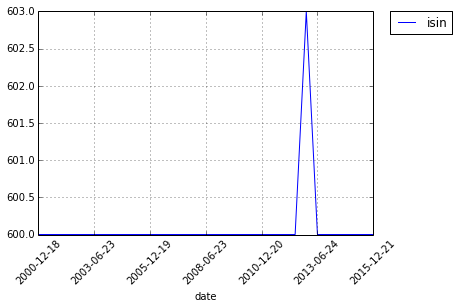

In [7]:
df.groupby('date').count()['isin'].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)

In [10]:
#full download
import pandas as pd
import numpy as np
import datetime as dt
import sys
import pyodbc
import time

import myfunctions as myf
import qadconnect34 as q

creds = 'DRIVER={SQL Server};SERVER=mpzhwindex01;DATABASE=qai;UID=stx-ro;PWD=stx-ro'
con = pyodbc.connect(creds)

sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')

bojloc ='G:/stoxx/STOXX/Product Development & Research/Projects/2134 iSTOXX Bank of Japan BoJ Capex/'
histloc = bojloc + '03 History/'
calcloc = histloc + '01 calc steps/'

def get_jplocal(infocodes):
    sqlstr = """
    select InfoCode as infocode, DsLocalCode as jplocal from DS2CtryQtInfo where InfoCode in (%s)
    """ % (infocodes)
    try:
        res= pd.io.sql.read_sql(sqlstr,con)
        return res
    except:
        return np.nan

#data download
def get_wsfields_last_reported_table(sedol, codes, isocode):
    sqlstr = """
    select a.code, a.item, a.freq, a.year_, a.seq, a.epsReportDate as date_, a.value_, a.itemUnits as isocode from [vw_WSItemData] a
    JOIN Wsinfo u on u.Code = a.Code
    where u.Sedol = '%s'
    and Item in (%s)
    and a.freq in ('S','A','Q','R')
    and itemUnits = '%s'
    order by epsReportDate desc, year_ desc
    """ % (str(sedol)[0:6], codes, isocode)
    try:
        res= pd.io.sql.read_sql(sqlstr,con)
        return res
    except:
        return np.nan

def get_op_income(sedol, d, isocode, df):

    #Operating income
    df1 = df[(df.item==1250) & (df.date_<=d)] 
    if len(df1)>0:
        
        df0=df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq'].isin(list(('S','A'))))]
        if len(df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')])>0:
            op_i = df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_'] 
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')])==4:
            op_i = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')].sum()['value_']
        elif (len(df0)>=3) & (len(df0[df0['freq']=='S'])>1) & (len(df0[df0['freq']=='A'])>=1) & (len(df0[(df0['freq']=='S') & (df0['seq']==2)])==1):
            a1=df0[df0['freq']=='A'].reset_index(drop=True).loc[0,'value_']
            s2=df0[(df0['freq']=='S') & (df0['seq']==2)].reset_index(drop=True).loc[0,'value_']
            if a1!=s2:
                op_i = df0[df0['freq']=='S'].sum()['value_']
            elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
                op_i = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            else:
                op_i = 0
        elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
            op_i = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
        else:
            op_i = 0
    else:
        op_i = 0
        
    return float(op_i)
    
def get_net_income(sedol, d, isocode, df):

    #Net Income Before Extraordinary Items/Preferred Dividends
    df1 = df[(df.item==1551) & (df.date_<=d)] 
    if len(df1)>0:
        
        df0=df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq'].isin(list(('S','A'))))]
        if len(df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')])>0:
            net_i_bef = df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_'] 
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')])==4:
            net_i_bef = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')].sum()['value_']
        elif (len(df0)>=3) & (len(df0[df0['freq']=='S'])>1) & (len(df0[df0['freq']=='A'])>=1) & (len(df0[(df0['freq']=='S') & (df0['seq']==2)])==1):
            a1=df0[df0['freq']=='A'].reset_index(drop=True).loc[0,'value_']
            s2=df0[(df0['freq']=='S') & (df0['seq']==2)].reset_index(drop=True).loc[0,'value_']
            if a1!=s2:
                net_i_bef = df0[df0['freq']=='S'].sum()['value_']
            elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
                net_i_bef = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            else:
                net_i_bef = 0
        elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
            net_i_bef = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
        else:
            net_i_bef = 0
    else:
        net_i_bef = 0
    
    #Discontinued Operation
    df1 = df[(df.item==1505) & (df.date_<=d)] 
    if len(df1)>0:

        df0=df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq'].isin(list(('S','A'))))]
        if len(df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')])>0:
            disc_ops = df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')])==4:
            disc_ops = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')].sum()['value_']
        elif (len(df0)>=3) & (len(df0[df0['freq']=='S'])>1) & (len(df0[df0['freq']=='A'])>=1) & (len(df0[(df0['freq']=='S') & (df0['seq']==2)])==1):
            a1=df0[df0['freq']=='A'].reset_index(drop=True).loc[0,'value_']
            s2=df0[(df0['freq']=='S') & (df0['seq']==2)].reset_index(drop=True).loc[0,'value_']
            if a1!=s2:
                disc_ops = df0[df0['freq']=='S'].sum()['value_']
            elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
                disc_ops = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            else:
                disc_ops = 0
        elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
            disc_ops = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
        else:
            disc_ops = 0
    else:
        disc_ops = 0    
    
    return float(net_i_bef)-float(disc_ops)

#aggregated value based on output from get_wsfields_last_reported_table
def get_ws_agg(df, item_, d):
    df1 = df[(df.item==item_) & (df.date_<=d)]
    if len(df1)>0:
        
        dfcond = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='S')] #needed for case S1
        if len(df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_'] #in there's an A in the last 3 months
            x = 'A4'

        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')])==4:
            val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')].sum()['value_']
            x = 'Q12'

        elif len(df1[(df1['date_']>=myf.add_months(d,-6)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-6)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A6'

        elif len(df1[(df1['date_']>=myf.add_months(d,-7)) & (df1['freq']=='S') & (df1['seq']==2)])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-7)) & (df1['freq']=='S') & (df1['seq']==2)].reset_index(drop=True).loc[0,'value_']
            x = 'S2'

        elif len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)])>=3:
            if df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True).loc[0,'seq']==4:
                val = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True).loc[0,'value_']
                x = 'R4'
            else:
                df0=df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True)
                val = df0.loc[0,'value_'] + df0.loc[1,'value_'] - df0.loc[2,'value_']
                x = 'R2'

        elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A9'
            
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1.freq=='A')])==1:
            anval = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1.freq=='A')].reset_index(drop=True).loc[0,'value_']
            if len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==3)])==2:
                dfR = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==3)].reset_index(drop=True).sort(['date_','year_'], ascending=[False, False])
                val = dfR.loc[0,'value_'] - dfR.loc[1,'value_'] + anval
                x = 'AR3'

            elif len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==2)])==2:
                dfR = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==2)].reset_index(drop=True).sort(['date_','year_'], ascending=[False, False])
                val = dfR.loc[0,'value_'] - dfR.loc[1,'value_'] + anval
                x = 'AR2'
            else:
                val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
                x = 'A12'
                
        elif  (len(dfcond)>2):
            if (dfcond.reset_index(drop=True).loc[0,'seq']==1): 
                df0=df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='S')].reset_index(drop=True)
                val = df0.loc[0,'value_'] + df0.loc[1,'value_'] - df0.loc[2,'value_'] 
                x = 'S1'
            else:
                val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
                x = 'A12'
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A12'
        else:
            val = 0
            x = '-'
    
    else:
        val = np.nan
    
    return val


dfin = pd.read_csv(calcloc +'02_jp600_info.csv', sep=';')
del dfin['dt']
dfin = dfin[dfin.date>='2002-06-01'].sort(['date','isin'], ascending=[True, True]).reset_index(drop=True)
#df.groupby('date').count()

#small sample for test
#dfin = dfin.iloc[-20:,:]
#dfin = dfin[(dfin.date=='2004-12-20') & (dfin.sedol=='6259011')]

time1=time.time()

#delete reits
icb_reit = ['8671','8672','8673','8674','8675','8676','8677','8737','8733',8671,8672,8673,8674,8675,8676,8677,8737,8733,'REA']
dfin = dfin[-dfin.icb.isin(list(icb_reit))]

#list of traded days for universe, for adtv calc
f='SX60JP'
url='http://www.stoxx.com/download/historical_data/h_'+f.lower()+'.txt'
dfweb = myf.get_web_h([f], usedates=True)
dfweb['Date']=pd.to_datetime(dfweb['Date'], format='%d.%m.%Y', dayfirst=True)
dfweb = dfweb[-dfweb[f].isnull()].sort('Date', ascending=True).reset_index(drop=True)

wst=[]
wslist=['3995', #Total Shareholders’ Equity # 0
        '3995-1', #Total Shareholders’ Equity # 1
        '3995-2', #Total Shareholders’ Equity # 2
        '3255', #Total Debt # 3
        '2999', #Total Assets # 4
        '2501', #Property, Plant And Equipment - Net # 5
        '2101', #Inventories - Total # 6
        '2051', #Receivables (Net) # 7
        '4860', #NET CASH FLOW from OPERATING ACTIVITIES (12 Month trailing) # 8
        'NI', #1551-1505: Net Income = Net Income Before Extraordinary Items/Preferred Dividends - Discontinued Operations # 9
        'NI-1', # 10
        'NI-2', # 11
        'NI-3', # 12
        'NI-4', # 13
        'NIstdev', # 14
        '4601', #capex (additions to fixed assets) # 15
        '4651', #additions to other assets # 16
        '4601-1', #capex (additions to fixed assets) # 17
        '4651-1', #additions to other assets # 18
        '4601-2', #capex (additions to fixed assets) # 19
        '4651-2', #additions to other assets # 20
        '1151', #Depreciation, Depletion & Amortization # 21
        '1151-1', #Depreciation, Depletion & Amortization # 22
        '1151-2', #Depreciation, Depletion & Amortization # 23
        'capex', #4601+4651 # 24
        'capex-1', # 25
        'capex-2', # 26
        'excapex', #capex-1151 # 27
        'excapex-1', # 28
        'excapex-2', # 29        
        'RD', #R&D (field 1201) 30
        'RD-1', #R&D 31
        'RD-2', #R&D 32
        '1250', #Operating Income, for BOJ credit risk requirement #33
        '1250-1', #34
        '1250-2', #35
        'tval_1y', # 36
        'tdays_1y', # 37
        'adtv', # 38
        'prim_exch', # 39
        'sedol', # 40
        'date'] # 41

print(len(dfin))
ct=0
for sed in dfin['sedol'].drop_duplicates().reset_index(drop=True):
    
    #print(sed)
    
    dfsed = dfin[dfin.sedol==sed].reset_index(drop=True)
    wsdata = [[0 for x in range(len(wslist))] for x in range(len(dfsed))]
    cur = dfsed.loc[0, 'curr']
    df = get_wsfields_last_reported_table(sed, "'3995','3255', '2999', '2501', '2101', '2051', '4860','1551','1505','4601','4651','1151','1201','1250'", cur)
    
    for index, row in dfsed.iterrows():
        
        #d=pd.to_datetime(row.date, format='%Y-%m-%d', dayfirst=True)
        d=dt.datetime.strptime(row.date, '%Y-%m-%d')
        d=d-dt.timedelta(days=(d.day))
        d1=d + dt.timedelta(days=1) #first day of the month - needed for adtv calc
        
        #latest value items
        try:
            wsdata[index][0] = df[(df.item==3995) & (df.date_<=d)].sort(['date_', 'year_'], ascending=[False,False]).reset_index(drop=True).loc[0,'value_']
        except:
            wsdata[index][0] = np.nan
        try:
            wsdata[index][1] = df[(df.item==3995) & (df.date_<=myf.add_months(d,-12))].sort(['date_', 'year_'], ascending=[False,False]).reset_index(drop=True).loc[0,'value_']
        except:
            wsdata[index][1] = np.nan
        try:
            wsdata[index][2] = df[(df.item==3995) & (df.date_<=myf.add_months(d,-24))].sort(['date_', 'year_'], ascending=[False,False]).reset_index(drop=True).loc[0,'value_']
        except:
            wsdata[index][2] = np.nan
        try:
            wsdata[index][3] = df[(df.item==3255) & (df.date_<=d)].sort(['date_', 'year_'], ascending=[False,False]).reset_index(drop=True).loc[0,'value_']
        except:
            wsdata[index][3] = np.nan
        try:
            wsdata[index][4] = df[(df.item==2999) & (df.date_<=d)].sort(['date_', 'year_'], ascending=[False,False]).reset_index(drop=True).loc[0,'value_']
        except:
            wsdata[index][4] = np.nan
        try:
            wsdata[index][5] = df[(df.item==2501) & (df.date_<=d)].sort(['date_', 'year_'], ascending=[False,False]).reset_index(drop=True).loc[0,'value_']
        except:
            wsdata[index][5] = np.nan
        try:
            wsdata[index][6] = df[(df.item==2101) & (df.date_<=d)].sort(['date_', 'year_'], ascending=[False,False]).reset_index(drop=True).loc[0,'value_']
        except:
            wsdata[index][6] = np.nan
        try:
            wsdata[index][7] = df[(df.item==2051) & (df.date_<=d)].sort(['date_', 'year_'], ascending=[False,False]).reset_index(drop=True).loc[0,'value_']
        except:
            wsdata[index][7] = np.nan

        #aggregated
        wsdata[index][8] = get_ws_agg(df, 4860, d)
        
        #to calculate standard deviation of NI
        wsdata[index][9] = get_net_income(row.sedol, d, cur, df)
        wsdata[index][10] = get_net_income(row.sedol, myf.add_months(d,-12), cur, df)
        wsdata[index][11] = get_net_income(row.sedol, myf.add_months(d,-24), cur, df)
        wsdata[index][12] = get_net_income(row.sedol, myf.add_months(d,-36), cur, df)
        wsdata[index][13] = get_net_income(row.sedol, myf.add_months(d,-48), cur, df)
                
        ni_h=np.array(list([wsdata[index][9], wsdata[index][10], wsdata[index][11], wsdata[index][12], wsdata[index][13]]))
        if len(ni_h[ni_h!=0])>=3:
            wsdata[index][14] = np.std(ni_h[ni_h!=0], ddof=1)
        else:
            wsdata[index][14] = 0
            
        #more aggregated values
        wsdata[index][15] = get_ws_agg(df, 4601, d)
        wsdata[index][16] = get_ws_agg(df, 4651, d)
        wsdata[index][17] = get_ws_agg(df, 4601, myf.add_months(d,-12))
        wsdata[index][18] = get_ws_agg(df, 4651, myf.add_months(d,-12))
        wsdata[index][19] = get_ws_agg(df, 4601, myf.add_months(d,-24))
        wsdata[index][20] = get_ws_agg(df, 4651, myf.add_months(d,-24))
        wsdata[index][21] = get_ws_agg(df, 1151, d)
        wsdata[index][22] = get_ws_agg(df, 1151, myf.add_months(d,-12))
        wsdata[index][23] = get_ws_agg(df, 1151, myf.add_months(d,-24))
        wsdata[index][24] = wsdata[index][15] + wsdata[index][16] #capex
        wsdata[index][25] = wsdata[index][17] + wsdata[index][18]
        wsdata[index][26] = wsdata[index][19] + wsdata[index][20]
        wsdata[index][27] = wsdata[index][24] - wsdata[index][21] #excapex
        wsdata[index][28] = wsdata[index][25] - wsdata[index][22]
        wsdata[index][29] = wsdata[index][26] - wsdata[index][23]
        
        #latest value vor R&D
        try:
            wsdata[index][30] = df[(df.item==1201) & (df.date_<=d)].sort(['date_', 'year_'], ascending=[False,False]).reset_index(drop=True).loc[0,'value_']
        except:
            wsdata[index][30] = np.nan
        try:
            wsdata[index][31] = df[(df.item==1201) & (df.date_<=myf.add_months(d,-12))].sort(['date_', 'year_'], ascending=[False,False]).reset_index(drop=True).loc[0,'value_']
        except:
            wsdata[index][31] = np.nan
        try:
            wsdata[index][32] = df[(df.item==1201) & (df.date_<=myf.add_months(d,-24))].sort(['date_', 'year_'], ascending=[False,False]).reset_index(drop=True).loc[0,'value_']
        except:
            wsdata[index][32] = np.nan
            
        #more aggregated values for operating income
        wsdata[index][33] = get_op_income(row.sedol, d, cur, df)
        wsdata[index][34] = get_op_income(row.sedol, myf.add_months(d,-12), cur, df)
        wsdata[index][35] = get_op_income(row.sedol, myf.add_months(d,-24), cur, df)

        #adtv import and calculation 
        #includes trading frm Osaka (exchange #150)
        if not np.isnan(q.get_infocode(row.sedol)):
            dfsecond = q.get_adtv_sec_plus(row.sedol, d, myf.add_months(d,-13), cur)
            dfsecond = dfsecond[dfsecond.exch==150]
            dfsecond = dfsecond[-dfsecond.close_.isnull()].sort('marketdate', ascending=False).reset_index(drop=True)
        else:
            if not np.isnan(q.get_infocode(row['isin'])):
                dfsecond = q.get_adtv_sec_plus(row['isin'], d, myf.add_months(d,-13), cur)
                dfsecond = dfsecond[dfsecond.exch==150]
                dfsecond = dfsecond[-dfsecond.close_.isnull()].sort('marketdate', ascending=False).reset_index(drop=True)
            else:
                dfsecond = pd.DataFrame(columns=['marketdate','close_','volume','exch'])
        
        if not np.isnan(row.infocode):
            adtv_= q.get_adtv_prim_plus(row.sedol, d, myf.add_months(d,-13), cur, int(row.infocode))
        else:
            adtv_= q.get_adtv_prim_plus(row.sedol, d, myf.add_months(d,-13), cur)
        
        if len(adtv_)==0:
            wsdata[index][36] = 0
            wsdata[index][37] = 0
            wsdata[index][38] = 0
            wsdata[index][39] = 0
        else: 
            adtv_=adtv_[-adtv_.close_.isnull()].sort('marketdate', ascending=False).reset_index(drop=True)
            
            dfctdays = adtv_[(adtv_['marketdate']<=d) & (adtv_['marketdate']>=myf.add_months(d1,-3))].sort('marketdate', ascending=False).reset_index(drop=True)
            dfctdays1y = adtv_[(adtv_['marketdate']<=d) & (adtv_['marketdate']>=myf.add_months(d1,-12))].sort('marketdate', ascending=False).reset_index(drop=True) 
            
            dfadtvsec = dfsecond[(dfsecond['marketdate']<=d) & (dfsecond['marketdate']>=myf.add_months(d1,-3))].sort('marketdate', ascending=False).reset_index(drop=True)
            dfadtvsec1y = dfsecond[(dfsecond['marketdate']<=d) & (dfsecond['marketdate']>=myf.add_months(d1,-12))].sort('marketdate', ascending=False).reset_index(drop=True)
            
            if len(dfctdays1y)>0:
                dfadtv1y = dfctdays1y.iloc[:,[0,1,2]]
                prim_ex = dfctdays1y.iloc[0,3]
                
                sum_sec = 0
                len_sec = 0
                if len(dfadtvsec1y)>0:
                    sum_sec = (dfadtvsec1y.loc[:,'close_'] * dfadtvsec1y.loc[:,'volume']).sum()
                    len_sec = len(dfadtvsec1y.loc[:,'close_'])
                    
                val_sum = (dfadtv1y.loc[:,'close_'] * dfadtv1y.loc[:,'volume']).sum() + sum_sec
                wsdata[index][36] = val_sum
                wsdata[index][37] = max(len(dfadtv1y.loc[:,'close_']), len_sec)
                wsdata[index][39] = prim_ex
            
            if len(dfctdays)>0:
                dfadtv = dfctdays.iloc[:,[0,1,2]]

                sum_sec_3m = 0
                len_sec_3m = 0
                if len(dfadtvsec)>0:
                    sum_sec_3m = (dfadtvsec.loc[:,'close_'] * dfadtvsec.loc[:,'volume']).sum()
                    len_sec_3m = len(dfadtvsec.loc[:,'close_'])
                
                adtv_3m = ((dfadtv.loc[:,'close_'] * dfadtv.loc[:,'volume']).sum() + sum_sec_3m) / (max(len(dfctdays), len_sec_3m))
                wsdata[index][38] = adtv_3m
                

        wsdata[index][40] = sed
        wsdata[index][41] = row.date

        if ct==0:
            wsdataall = pd.DataFrame(wsdata, columns=wslist)
        else:
            wsdataall = pd.concat([wsdataall, pd.DataFrame(wsdata, columns=wslist)], axis=0)
        
        if not (ct+1) % 100:
            print(' -- ', ct+1, ' -- ')
            
        ct=ct+1
        
dfin = pd.merge(dfin, wsdataall, how='left', left_on=['date','sedol'], right_on=['date','sedol']).sort(['date','isin'], ascending=[True, True]).drop_duplicates()        

#####
#get jp local ticker
infocodes = ''
for ic in dfin['infocode'].drop_duplicates():
    infocodes = infocodes + "'" + str(ic) + "',"
infocodes = infocodes[:len(infocodes)-1]
dfloc = get_jplocal(infocodes)
dfloc['jplocal'] = dfloc['jplocal'].map(lambda x: x[1:])
dfin = pd.merge(dfin, dfloc, how='left', on='infocode')


time2=time.time()
print('time elapsed:', (time2-time1)/60, 'minutes')

dfin.to_csv(calcloc + '03_jp600_data.csv' ,sep=';',index=False)
print('done')

28
time elapsed: 0.2179717977841695 minutes
done


In [44]:
q.get_adtv_prim_plus('6639550', '2013-06-01', '2013-01-01', cur)
s =q.get_adtv_sec_plus('6639550', '2013-06-01', '2012-01-01', cur)
s.exch.drop_duplicates()

0    150
Name: exch, dtype: int64

In [48]:
dfctdays1y.iloc[0,3]

200

In [31]:
#adtv, traded volume - old

import pandas as pd
import numpy as np
import datetime as dt
import sys
import pyodbc
import time

import myfunctions as myf
import qadconnect34 as q

creds = 'DRIVER={SQL Server};SERVER=mpzhwindex01;DATABASE=qai;UID=stx-ro;PWD=stx-ro'
con = pyodbc.connect(creds)

sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')

bojloc ='G:/stoxx/STOXX/Product Development & Research/Projects/2134 iSTOXX Bank of Japan BoJ Capex/'
histloc = bojloc + '03 History/'
calcloc = histloc + '01 calc steps/'

dfin = pd.read_csv(calcloc +'02_jp600_info.csv', sep=';')
del dfin['dt']
dfin = dfin[dfin.date>='2002-12-23'].sort(['date','isin'], ascending=[True, True]).reset_index(drop=True)
#df.groupby('date').count()

dfin = dfin.iloc[:,:] #small sample for test
dfin = dfin[dfin.sedol=='6900643']
#dfin = dfin[dfin.date=='2015-12-21']

time1=time.time()

#delete reits
icb_reit = ['8671','8672','8673','8674','8675','8676','8677','8737','8733',8671,8672,8673,8674,8675,8676,8677,8737,8733,'REA']
dfin = dfin[-dfin.icb.isin(list(icb_reit))]

#list of traded days for universe, for adtv calc
f='SX60JP'
url='http://www.stoxx.com/download/historical_data/h_'+f.lower()+'.txt'
dfweb = myf.get_web_h([f], usedates=True)
dfweb['Date']=pd.to_datetime(dfweb['Date'], format='%d.%m.%Y', dayfirst=True)
dfweb = dfweb[-dfweb[f].isnull()].sort('Date', ascending=True).reset_index(drop=True)

wst=[]
wslist=['tval_1y', #0
        'tdays_1y', #1
        'adtv', #2
        'sedol', #3
        'date'] #4

print(len(dfin))
ct=0
for sed in dfin['sedol'].drop_duplicates().reset_index(drop=True):
    
    #print(sed)
    
    dfsed = dfin[dfin.sedol==sed].reset_index(drop=True)
    wsdata = [[0 for x in range(len(wslist))] for x in range(len(dfsed))]
    cur = dfsed.loc[0, 'curr']
    
    for index, row in dfsed.iterrows():
        
        #d=pd.to_datetime(row.date, format='%Y-%m-%d', dayfirst=True)
        d=dt.datetime.strptime(row.date, '%Y-%m-%d')
        d=d-dt.timedelta(days=(d.day))
        d1=d + dt.timedelta(days=1) #first day of the month - needed for adtv calc 

        #adtv import and calculation
        if not np.isnan(row.infocode):
            adtv_= q.get_adtv_prim_plus(row.sedol, d, myf.add_months(d,-13), cur, int(row.infocode))
        else:
            adtv_= q.get_adtv_prim_plus(row.sedol, d, myf.add_months(d,-13), cur)
        
        if len(adtv_)==0:
            wsdata[index][0] = 0
            wsdata[index][1] = 0
            wsdata[index][2] = 0
        else: 
            adtv_=adtv_[-adtv_.close_.isnull()].sort('marketdate', ascending=False).reset_index(drop=True)
        
            dfctdays = adtv_[(adtv_['marketdate']<=d) & (adtv_['marketdate']>=myf.add_months(d1,-3))].sort('marketdate', ascending=False).reset_index(drop=True)
            dfctdays1y = adtv_[(adtv_['marketdate']<=d) & (adtv_['marketdate']>=myf.add_months(d1,-12))].sort('marketdate', ascending=False).reset_index(drop=True) 
            
            if len(dfctdays1y)>0:
                dfadtv1y = dfctdays1y.iloc[:,[0,1,2]]
                wsdata[index][0] = (dfadtv1y.loc[:,'close_'] * dfadtv1y.loc[:,'volume']).sum()
                wsdata[index][1] = len(dfadtv1y.loc[:,'close_'])
            
            if len(dfctdays)>0:
                dfadtv = dfctdays.iloc[:,[0,1,2]]
                wsdata[index][2] = (dfadtv.loc[:,'close_'] * dfadtv.loc[:,'volume']).sum() / len(dfctdays)

        wsdata[index][3] = sed
        wsdata[index][4] = row.date

        if ct==0:
            wsdataall = pd.DataFrame(wsdata, columns=wslist)
        else:
            wsdataall = pd.concat([wsdataall, pd.DataFrame(wsdata, columns=wslist)], axis=0)
        
        if not (ct+1) % 100:
            print(' -- ', ct+1, ' -- ')
            
        ct=ct+1
        
dfin = pd.merge(dfin, wsdataall, how='left', left_on=['date','sedol'], right_on=['date','sedol']).sort(['date','isin'], ascending=[True, True]).drop_duplicates()        

#####

time2=time.time()
print('time elapsed:', (time2-time1)/60, 'minutes')

dfin.to_csv(calcloc + '03_jp600_data_adtv.csv' ,sep=';',index=False)
print('done')


27
time elapsed: 0.009296667575836182 minutes
done


In [163]:
#dfctdays1y.to_csv(calcloc + '6900643_data_adtv.csv' ,sep=';',index=False)
x = q.get_adtv_prim_plus('JP3142350002', '2013-06-30', '2013-01-01', 'JPY', int(36975))
y = q.get_adtv_sec_plus('JP3142350002', '2013-06-30', '2013-01-01', 'JPY')
#x[x.Exch==150].head()
y.exch.drop_duplicates()


0    200
Name: exch, dtype: int64

In [147]:
q.get_adtv_prim_plus('6499293', '2013-05-31', '2007-06-01', 'JPY')

x =q.get_adtv_sec_plus('6610403', '2015-05-31', '2007-06-01', 'JPY')
x

In [73]:
#reduced download - compare few fields
import pandas as pd
import numpy as np
import datetime as dt
import sys
import pyodbc
import time

import myfunctions as myf
import qadconnect34 as q

creds = 'DRIVER={SQL Server};SERVER=mpzhwindex01;DATABASE=qai;UID=stx-ro;PWD=stx-ro'
con = pyodbc.connect(creds)

sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')

bojloc ='G:/stoxx/STOXX/Product Development & Research/Projects/2134 iSTOXX Bank of Japan BoJ Capex/'
histloc = bojloc + '03 History/'
calcloc = histloc + '01 calc steps/'

#data download
def get_wsfields_last_reported_table(sedol, codes, isocode):
    sqlstr = """
    select a.code, a.item, a.freq, a.year_, a.seq, a.epsReportDate as date_, a.value_, a.itemUnits as isocode from [vw_WSItemData] a
    JOIN Wsinfo u on u.Code = a.Code
    where u.Sedol = '%s'
    and Item in (%s)
    and a.freq in ('S','A','Q','R')
    and itemUnits = '%s'
    order by epsReportDate desc, year_ desc
    """ % (str(sedol)[0:6], codes, isocode)
    try:
        res= pd.io.sql.read_sql(sqlstr,con)
        return res
    except:
        return np.nan

def get_net_income(sedol, d, isocode, df):

    #Net Income Before Extraordinary Items/Preferred Dividends
    df1 = df[(df.item==1551) & (df.date_<=d)] 
    if len(df1)>0:
        
        df0=df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq'].isin(list(('S','A'))))]
        if len(df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')])>0:
            net_i_bef = df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_'] 
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')])==4:
            net_i_bef = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')].sum()['value_']
        elif (len(df0)>=3) & (len(df0[df0['freq']=='S'])>1) & (len(df0[df0['freq']=='A'])>=1) & (len(df0[(df0['freq']=='S') & (df0['seq']==2)])==1):
            a1=df0[df0['freq']=='A'].reset_index(drop=True).loc[0,'value_']
            s2=df0[(df0['freq']=='S') & (df0['seq']==2)].reset_index(drop=True).loc[0,'value_']
            if a1!=s2:
                net_i_bef = df0[df0['freq']=='S'].sum()['value_']
            elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
                net_i_bef = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            else:
                net_i_bef = 0
        elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
            net_i_bef = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
        else:
            net_i_bef = 0
    else:
        net_i_bef = 0
    
    #Discontinued Operation
    df1 = df[(df.item==1505) & (df.date_<=d)] 
    if len(df1)>0:

        df0=df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq'].isin(list(('S','A'))))]
        if len(df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')])>0:
            disc_ops = df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')])==4:
            disc_ops = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')].sum()['value_']
        elif (len(df0)>=3) & (len(df0[df0['freq']=='S'])>1) & (len(df0[df0['freq']=='A'])>=1) & (len(df0[(df0['freq']=='S') & (df0['seq']==2)])==1):
            a1=df0[df0['freq']=='A'].reset_index(drop=True).loc[0,'value_']
            s2=df0[(df0['freq']=='S') & (df0['seq']==2)].reset_index(drop=True).loc[0,'value_']
            if a1!=s2:
                disc_ops = df0[df0['freq']=='S'].sum()['value_']
            elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
                disc_ops = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            else:
                disc_ops = 0
        elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
            disc_ops = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
        else:
            disc_ops = 0
    else:
        disc_ops = 0    
    
    return float(net_i_bef)-float(disc_ops)

#aggregated value based on output from get_wsfields_last_reported_table
def get_ws_agg(df, item_, d):
    df1 = df[(df.item==item_) & (df.date_<=d)]
    if len(df1)>0:
        
        dfcond = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='S')] #needed for case S1
        if len(df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_'] #in there's an A in the last 3 months
            x = 'A4'

        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')])==4:
            val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')].sum()['value_']
            x = 'Q12'

        elif len(df1[(df1['date_']>=myf.add_months(d,-6)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-6)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A6'

        elif len(df1[(df1['date_']>=myf.add_months(d,-7)) & (df1['freq']=='S') & (df1['seq']==2)])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-7)) & (df1['freq']=='S') & (df1['seq']==2)].reset_index(drop=True).loc[0,'value_']
            x = 'S2'

        elif len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)])>=3:
            if df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True).loc[0,'seq']==4:
                val = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True).loc[0,'value_']
                x = 'R4'
            else:
                df0=df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True)
                val = df0.loc[0,'value_'] + df0.loc[1,'value_'] - df0.loc[2,'value_']
                x = 'R2'

        elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A9'
            
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1.freq=='A')])==1:
            anval = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1.freq=='A')].reset_index(drop=True).loc[0,'value_']
            if len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==3)])==2:
                dfR = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==3)].reset_index(drop=True).sort(['date_','year_'], ascending=[False, False])
                val = dfR.loc[0,'value_'] - dfR.loc[1,'value_'] + anval
                x = 'AR3'

            elif len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==2)])==2:
                dfR = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==2)].reset_index(drop=True).sort(['date_','year_'], ascending=[False, False])
                val = dfR.loc[0,'value_'] - dfR.loc[1,'value_'] + anval
                x = 'AR2'
            else:
                val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
                x = 'A12'
                
        elif  (len(dfcond)>2):
            if (dfcond.reset_index(drop=True).loc[0,'seq']==1): 
                df0=df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='S')].reset_index(drop=True)
                val = df0.loc[0,'value_'] + df0.loc[1,'value_'] - df0.loc[2,'value_'] 
                x = 'S1'
            else:
                val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
                x = 'A12'
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A12'
        else:
            val = 0
            x = '-'
    
    else:
        val = np.nan
    
    return val

#aggregated value based on output from get_wsfields_last_reported_table
def get_ws_agg_typ(df, item_, d):
    df1 = df[(df.item==item_) & (df.date_<=d)]
    if len(df1)>0:
        
        dfcond = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='S')] #needed for case S1
        if len(df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_'] #in there's an A in the last 3 months
            x = 'A4'

        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')])==4:
            val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')].sum()['value_']
            x = 'Q12'

        elif len(df1[(df1['date_']>=myf.add_months(d,-6)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-6)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A6'

        elif len(df1[(df1['date_']>=myf.add_months(d,-7)) & (df1['freq']=='S') & (df1['seq']==2)])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-7)) & (df1['freq']=='S') & (df1['seq']==2)].reset_index(drop=True).loc[0,'value_']
            x = 'S2'

        elif len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)])>=3:
            if df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True).loc[0,'seq']==4:
                val = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True).loc[0,'value_']
                x = 'R4'
            else:
                df0=df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True)
                val = df0.loc[0,'value_'] + df0.loc[1,'value_'] - df0.loc[2,'value_']
                x = 'R2'

        elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A9'
            
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1.freq=='A')])==1:
            anval = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1.freq=='A')].reset_index(drop=True).loc[0,'value_']
            if len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==3)])==2:
                dfR = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==3)].reset_index(drop=True).sort(['date_','year_'], ascending=[False, False])
                val = dfR.loc[0,'value_'] - dfR.loc[1,'value_'] + anval
                x = 'AR3'

            elif len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==2)])==2:
                dfR = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==2)].reset_index(drop=True).sort(['date_','year_'], ascending=[False, False])
                val = dfR.loc[0,'value_'] - dfR.loc[1,'value_'] + anval
                x = 'AR2'
            else:
                val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
                x = 'A12'
                
        elif  (len(dfcond)>2):
            if (dfcond.reset_index(drop=True).loc[0,'seq']==1): 
                df0=df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='S')].reset_index(drop=True)
                val = df0.loc[0,'value_'] + df0.loc[1,'value_'] - df0.loc[2,'value_'] 
                x = 'S1'
            else:
                val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
                x = 'A12'
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A12'
        else:
            val = 0
            x = '-'
    
    else:
        val = np.nan
        x = 'nada'
    
    return x

dfin = pd.read_csv(calcloc +'02_jp600_info.csv', sep=';')
del dfin['dt']
dfin = dfin[dfin.date>='2002-12-23'].sort(['date','isin'], ascending=[True, True]).reset_index(drop=True)
#df.groupby('date').count()

#small sample for test
dfin = dfin.iloc[-1200:,:]
#dfin = dfin[(dfin.date=='2004-12-20') & (dfin.sedol=='6259011')]

time1=time.time()

#delete reits
icb_reit = ['8671','8672','8673','8674','8675','8676','8677','8737','8733',8671,8672,8673,8674,8675,8676,8677,8737,8733,'REA']
dfin = dfin[-dfin.icb.isin(list(icb_reit))]

#list of traded days for universe, for adtv calc
f='SX60JP'
url='http://www.stoxx.com/download/historical_data/h_'+f.lower()+'.txt'
dfweb = myf.get_web_h([f], usedates=True)
dfweb['Date']=pd.to_datetime(dfweb['Date'], format='%d.%m.%Y', dayfirst=True)
dfweb = dfweb[-dfweb[f].isnull()].sort('Date', ascending=True).reset_index(drop=True)

wst=[]
wslist=['NI', #1551-1505: Net Income = Net Income Before Extraordinary Items/Preferred Dividends - Discontinued Operations # 0
        '1551_agg', # 1
        '1505_agg', # 2   
        'typ', # 3
        'sedol', # 4
        'date'] # 5
        
print(len(dfin))
ct=0
for sed in dfin['sedol'].drop_duplicates().reset_index(drop=True):
    
    #print(sed)
    
    dfsed = dfin[dfin.sedol==sed].reset_index(drop=True)
    wsdata = [[0 for x in range(len(wslist))] for x in range(len(dfsed))]
    cur = dfsed.loc[0, 'curr']
    df = get_wsfields_last_reported_table(sed, "'1551','1505'", cur)
    
    for index, row in dfsed.iterrows():
        
        #d=pd.to_datetime(row.date, format='%Y-%m-%d', dayfirst=True)
        d=dt.datetime.strptime(row.date, '%Y-%m-%d')
        d=d-dt.timedelta(days=(d.day))
        d1=d + dt.timedelta(days=1) #first day of the month - needed for adtv calc

        #NI
        wsdata[index][0] = get_net_income(row.sedol, d, cur, df)
            
        #more aggregated values
        wsdata[index][1] = get_ws_agg(df, 1551, d)
        wsdata[index][2] = get_ws_agg(df, 1505, d)
        wsdata[index][3] = get_ws_agg_typ(df, 1551, d)

        

        wsdata[index][4] = sed
        wsdata[index][5] = row.date

        if ct==0:
            wsdataall = pd.DataFrame(wsdata, columns=wslist)
        else:
            wsdataall = pd.concat([wsdataall, pd.DataFrame(wsdata, columns=wslist)], axis=0)
        
        if not (ct+1) % 100:
            print(' -- ', ct+1, ' -- ')
            
        ct=ct+1
        
dfin = pd.merge(dfin, wsdataall, how='left', left_on=['date','sedol'], right_on=['date','sedol']).sort(['date','isin'], ascending=[True, True]).drop_duplicates()        

#####

time2=time.time()
print('time elapsed:', (time2-time1)/60, 'minutes')

dfin.to_csv(calcloc + '03_jp600_data_income_comparison.csv' ,sep=';',index=False)
print('done')

1142
 --  100  -- 
 --  200  -- 
 --  300  -- 
 --  400  -- 
 --  500  -- 
 --  600  -- 
 --  700  -- 
 --  800  -- 
 --  900  -- 
 --  1000  -- 
 --  1100  -- 
time elapsed: 1.1811233321825663 minutes
done


In [5]:
dfinfo_temp.head(2)

,jplocal,yearmap,TKid,name_,web,employee_num,employee_num_parent,wage
0,1301,2015,10028306,"KYOKUYO CO.,LTD.",http://www.kyokuyo.co.jp/,2111,564,670
1,1332,2015,10002947,"NIPPON SUISAN KAISHA, LTD.",http://www.nissui.co.jp/,8362,1138,764


In [80]:
dfcsr = pd.read_excel(tkcsroloc + 'CSR.xlsx')
dfcsr = dfcsr.rename(columns={'year':'yearmap', 'toyo_company_id':'TKid'})
del dfcsr['published_date']
dfcsr.dtypes

yearmap      int64
TKid         int64
code       float64
K083       float64
K106       float64
K127       float64
K130       float64
K133       float64
K153       float64
K155       float64
K159       float64
K163       float64
K167       float64
K170       float64
K178       float64
K180       float64
K184       float64
K186       float64
dtype: object

In [106]:
#################csr data
dfcsr = pd.read_excel(tkcsroloc + 'CSR.xlsx')
dfcsr = dfcsr.rename(columns={'year':'yearmap', 'toyo_company_id':'TKid'})
del dfcsr['published_date']

#June 2016 review - csr data
dfcsrmap = pd.read_excel(tkcsroloc + 'CSR_map.xlsx')
#15 fields from csr
hccodes = ['K083','K106','K127','K130','K133','K153','K155','K159','K163','K167','K170','K178','K180','K184','K186']

f = 'koyou1_2016.csv'
dfcsr_ = pd.read_csv(tkcsroloc + 'CSR Data (HR)/' + f, encoding='iso-8859-1', sep=',', header=None)
dfcsr_ = dfcsr_.rename(columns={dfcsr_.columns[0]:'TKid', dfcsr_.columns[1]:'ticker'})
dfmap = dfcsrmap[['col', f]][dfcsrmap[f].isin(list(hccodes))]
for index, row in dfmap.iterrows():
    dfcsr_ = dfcsr_.rename(columns={row.col-1:row[f]})
hccodes.append('ticker')
hccodes.append('TKid')
dfcsr_ = dfcsr_[hccodes]
dfcsr_.head()
dfcsr_['yearmap'] = 2016
dfcsr_ = dfcsr_[[17,16,15,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]]
dfcsr_ = dfcsr_.rename(columns={'ticker':'code'})
dfcsr = pd.concat([dfcsr, dfcsr_], axis=0).sort('yearmap', ascending=True)
dfcsr.head()

,yearmap,TKid,code,K083,K106,K127,K130,K133,K153,K155,K159,K163,K167,K170,K178,K180,K184,K186
0,2006,10002947,1332,1.4,NaN,NaN,NaN,3.0,1,2,2,2,NaN,1,2,1,1,2
494,2006,10019594,8256,2.9,NaN,NaN,NaN,3.1,2,2,2,2,NaN,2,2,2,1,2
495,2006,10007482,9882,1.5,NaN,NaN,NaN,4.1,2,2,2,2,NaN,2,2,2,1,2
496,2006,10030609,9889,1.1,NaN,NaN,NaN,5.6,1,1,2,1,NaN,1,2,2,1,1
497,2006,10033678,9906,1.4,NaN,NaN,NaN,5.5,2,1,2,2,NaN,1,2,2,2,2


In [35]:
#use tk data - amended to include June2016
first_reb = '2008-06-01'

tkinfoloc = bojloc + '02 Data/Company Info data/Company Info data/'
tkcsroloc = bojloc + '02 Data/CSR Data (HR)/'
#dfjp = pd.read_csv(calcloc + '03_jp600_data.csv', sep=';').sort('date', ascending=True)
dfjp_new = pd.read_csv(calcloc + 'june2016/' +'03_jp600_data_.csv', sep=';', dtype={'jplocal': object}).sort('date', ascending=True)
dfjp_old = pd.read_csv(calcloc + 'june2016/' +'03_jp600_data.csv', sep=';', dtype={'jplocal': object}).sort('date', ascending=True)

dfjp = pd.concat([dfjp_old, dfjp_new], axis=0).sort('date', ascending=True)

dfjp = dfjp[dfjp.date>='2006-06-01'].sort(['date','isin'], ascending=[True, True]).reset_index(drop=True)
del dfjp['prim_exch']

#company info data
dfinfo = pd.DataFrame(); dfinfo_1 = pd.DataFrame(); dfinfo_2 = pd.DataFrame()
ct = 0
dfjp['yearmap'] = dfjp['date'].map(lambda x: int(x[:4]))
for d in dfjp['date'].drop_duplicates():
    if not ct % 2: #skip the second time
        yr = int(d[:4])-1
        print(d, yr)
        dfinfo_temp = pd.read_csv(tkinfoloc + 'Company Overview data_'+ str(yr) + '12.csv', encoding='iso-8859-1', sep=',')
        dfinfo_temp = dfinfo_temp[[0,1,5,23,25,26,28]]
        dfinfo_temp = dfinfo_temp.rename(columns={dfinfo_temp.columns[0]:'ticker'})
        dfinfo_temp['jplocal'] = dfinfo_temp['ticker'].map(lambda x: str(x))
        dfinfo_temp_1 = pd.DataFrame(np.array(dfinfo_temp))
        dfinfo_temp_2 = pd.DataFrame(np.array(dfinfo_temp))
        dfinfo_temp.columns = ['ticker','TKid','name_','web','employee_num','employee_num_parent','wage','jplocal']
        dfinfo_temp_1.columns = ['ticker','TKid','name_','web','employee_num-1','employee_num_parent-1','wage-1','jplocal']
        dfinfo_temp_2.columns = ['ticker','TKid','name_','web','employee_num-2','employee_num_parent-2','wage-2','jplocal']
        dfinfo_temp['yearmap'] = int(d[:4])
        dfinfo_temp_1['yearmap'] = int(d[:4]) + 1
        dfinfo_temp_2['yearmap'] = int(d[:4]) + 2
        dfinfo_temp = dfinfo_temp[[7,8,1,2,3,4,5,6]]
        dfinfo_temp_1 = dfinfo_temp_1[[7,8,4,5,6]]
        dfinfo_temp_2 = dfinfo_temp_2[[7,8,4,5,6]]
        
        dfinfo = pd.concat([dfinfo, dfinfo_temp], axis=0)
        dfinfo_1 = pd.concat([dfinfo_1, dfinfo_temp_1], axis=0)
        dfinfo_2 = pd.concat([dfinfo_2, dfinfo_temp_2], axis=0)
        
    ct = ct + 1

dfinfo = pd.merge(dfinfo, dfinfo_1, how='left', on= ['jplocal','yearmap'])
dfinfo = pd.merge(dfinfo, dfinfo_2, how='left', on= ['jplocal','yearmap'])
dfinfo.to_csv(calcloc + 'june2016/' + '04_data_hc.csv' ,sep=';',index=False)
dfjp = pd.merge(dfjp, dfinfo, how='left', on= ['jplocal','yearmap'])
#dfjp.to_csv(calcloc + 'june2016/' + '04_jp600_companyinfo_.csv' ,sep=';',index=False)

#################csr data
dfcsr = pd.read_excel(tkcsroloc + 'CSR.xlsx')
dfcsr = dfcsr.rename(columns={'year':'yearmap', 'toyo_company_id':'TKid'})
del dfcsr['published_date']

#June 2016 review - csr data
dfcsrmap = pd.read_excel(tkcsroloc + 'CSR_map.xlsx')
#15 fields from csr
hccodes = ['K083','K106','K127','K130','K133','K153','K155','K159','K163','K167','K170','K178','K180','K184','K186']

f = 'koyou1_2016.csv'
dfcsr_ = pd.read_csv(tkcsroloc + 'CSR Data (HR)/' + f, encoding='iso-8859-1', sep=',', header=None)
dfcsr_ = dfcsr_.rename(columns={dfcsr_.columns[0]:'TKid', dfcsr_.columns[1]:'ticker'})
dfmap = dfcsrmap[['col', f]][dfcsrmap[f].isin(list(hccodes))]
for index, row in dfmap.iterrows():
    dfcsr_ = dfcsr_.rename(columns={row.col-1:row[f]})
hccodes.append('ticker')
hccodes.append('TKid')
dfcsr_ = dfcsr_[hccodes]
dfcsr_.head()
dfcsr_['yearmap'] = 2016
dfcsr_ = dfcsr_[[17,16,15,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]]
dfcsr_ = dfcsr_.rename(columns={'ticker':'code'})
dfcsr = pd.concat([dfcsr, dfcsr_], axis=0).sort('yearmap', ascending=True)
###########################

dfjp = pd.merge(dfjp, dfcsr, how='left', on=['yearmap','TKid'])

dfjp = dfjp[dfjp.date>=first_reb].sort(['date','isin'], ascending=[True, True]).reset_index(drop=True)
#dfjp.to_csv(calcloc + '04_jp600_data_hc.csv' ,sep=';',index=False)
dfjp.to_csv(calcloc + 'june2016/' + '04_jp600_data_hc_.csv' ,sep=';',index=False)

print('done')
dfjp.head(3)

2006-06-19 2005
2007-06-18 2006
2008-06-23 2007
2009-06-22 2008
2010-06-21 2009
2011-06-20 2010
2012-06-18 2011
2013-06-24 2012
2014-06-23 2013
2015-06-22 2014
2016-06-20 2015
done


,date,isin,curr,fx,sedol,icb,ffmcap_eur,name,symbol,ICB_ind,...,K153,K155,K159,K163,K167,K170,K178,K180,K184,K186
0,2008-06-23,JP3102000001,JPY,0.005983,6010702,3355,6.460394e+09,NaN,NaN,3000,...,1,1,2,2,NaN,2,2,2,1,2
1,2008-06-23,JP3103000000,JPY,0.005983,6196550,8355,5.730641e+08,NaN,NaN,8000,...,1,2,2,2,NaN,1,2,2,2,2
2,2008-06-23,JP3103600007,JPY,0.005983,6010207,1757,5.532832e+08,NaN,NaN,1000,...,1,1,2,2,NaN,1,1,1,2,1


In [141]:
#check mapping works
dfinfo.dtypes
dfinfo['jplocal'] = dfinfo['ticker'].map(lambda x: str(x))
dfinfo.dtypes

df = pd.merge(dfjp, dfinfo[[0,1,2,9]], how='left', on='jplocal')
df.sort(['date', 'ffmcap_eur'], ascending=[True, False]).to_csv(calcloc + '03_jp600_data_plus_check.csv', sep=';', index=False)
print('done')

done


In [36]:
#capex and HR data aggregation functions

def getdelta1(series): #change excapex
    div_ = 3.
    if not (isnan(series[0]) & isnan(series[1]) & isnan(series[2])):
        if isnan(series[0]):
            val0 = 0
            div_ = div_ - 1
        else:
            val0 = series[0]
        if isnan(series[1]):
            val1 = 0
            div_ = div_ - 1
        else:
            val1 = series[1]
        if isnan(series[2]):
            val2 = 0
            div_ = div_ - 1
        else:
            val2 = series[2]
        avg_val = (val0 + val1 + val2) / div_

        if round(avg_val,4) >0:
            return 1
        else:
            return 0
    else:
        return 0
    
def getdelta2(series): #change capex / RD / wage
    div_ = 3.
    if not (isnan(series[0]) & isnan(series[1]) & isnan(series[2])):
        if isnan(series[0]):
            val0 = 0
            div_ = div_ - 1
        else:
            val0 = series[0]
        if isnan(series[1]):
            val1 = 0
            div_ = div_ - 1
        else:
            val1 = series[1]
        if isnan(series[2]):
            val2 = 0
            div_ = div_ - 1
        else:
            val2 = series[2]
        avg_val = (val0 + val1 + val2) / div_
        
        if round(val0,4) > round(avg_val,4):
            return 1
        else:
            return 0
    else:
        return 0

def getdelta3(series): #change number of employees
    div_ = 3.
    if not isnan(series[0]):
        val0 = series[0]
        if isnan(series[1]):
            val1 = 0
            div_ = div_ - 1
        else:
            val1 = series[1]
        if isnan(series[2]):
            val2 = 0
            div_ = div_ - 1
        else:
            val2 = series[2]
            
        avg_val_1 = (val0 + val1 + val2) / div_
        
        if round(val0,4) > round(avg_val_1,4):
            delta1 = 1
        else:
            delta1 = 0
    else:
        delta1 = np.nan
    
    div1_ = 3.
    if not (isnan(series[3])):
        if isnan(series[3]):
            val3 = 0
            div1_ = div1_ - 1
        else:
            val3 = series[3]
        if isnan(series[4]):
            val4 = 0
            div1_ = div1_ - 1
        else:
            val4 = series[4]
        if isnan(series[5]):
            val5 = 0
            div1_ = div1_ - 1
        else:
            val5 = series[5]
            
        avg_val_2 = (val3 + val4 + val5) / div1_
        
        if round(val3,4) > round(avg_val_2,4):
            delta2 = 1
        else:
            delta2 = 0
    else:
        delta2 = 0
        
    if not isnan(delta1):
        return delta1
    else:
        return delta2

def getdelta4(series): #work environment
    div_ = 3.
    if series[0]==1:
        val0 = 1
    else:
        val0 = 0
    if series[1]==1:
        val1 = 1
    else:
        val1 = 0
    if series[2]==1:
        val2 = 1
    else:
        val2 = 0
    if series[3]==1:
        val3 = 1
    else:
        val3 = 0
        
    if isnan(series[4]):
        val4 = 0
        div_ = div_ - 1
    else:
        val4 = series[4]    
    if isnan(series[5]):
        val5 = 0
        div_ = div_ - 1
    else:
        val5 = series[5]
    if isnan(series[6]):
        val6 = 0
        div_ = div_ - 1
    else:
        val6 = series[6]
    try:
        pv = (val4 + val5 + val6) / div_
        if round(val6,4) > round(pv,4):
            delta_pv = 1
        else:
            delta_pv = 0
    except:
        delta_pv = 0
    
    return (val0 + val1 + val2 + val3 + delta_pv) / 5. 

def getdelta5(series): #skill motivation
    if series[0]==1:
        val0 = 1
    else:
        val0 = 0
    if series[1]==1:
        val1 = 1
    else:
        val1 = 0
    if series[2]==1:
        val2 = 1
    else:
        val2 = 0
    if series[3]==1:
        val3 = 1
    else:
        val3 = 0
    if series[4]==1:
        val4 = 1
    else:
        val4 = 0         
        
    return (val0 + val1 + val2 + val3 + val4) / 5. 

def getdelta6(series): #empowering women
    if series[0]==1:
        val0 = 1
    else:
        val0 = 0
    if series[1]==1:
        val1 = 1
    else:
        val1 = 0
    if isnan(series[2]):
        val2 = 0
    elif series[2]>=30:
        val2 = 1
    elif series[2]>=15:
        val2 = 0.5
    else:
        val2 = 0
        
    return (val0 + val1 + val2) / 3. 

In [37]:
#run selection
import scipy.stats as stats

#dfjp= pd.read_csv(calcloc + '04_jp600_data_hc.csv' ,sep=';')
dfjp= pd.read_csv(calcloc + 'june2016/' + '04_jp600_data_hc_.csv' ,sep=';')

dfjp[['2501','2101','2051']].fillna(0, inplace=True)
dfjp['ROE'] = dfjp['NI'] / dfjp['3995']
dfjp['Cap2Asset'] = dfjp['3255'] / (dfjp['3995'] + dfjp['3255'])
dfjp['CFGenInd'] = dfjp.loc[dfjp[dfjp['ICB_ind']!=8000].index, '4860'] / (dfjp['2501'] + dfjp['2101'] + dfjp['2051'])
dfjp.loc[dfjp[dfjp['ICB_ind']==8000].index,'CFGenFin'] = dfjp.loc[dfjp[dfjp['ICB_ind']==8000].index, '4860'] / dfjp['2999']
dfjp['Stability'] = dfjp['NIstdev'] / dfjp['3995']

dfjp['ROE_missing'] = 'ok'
dfjp.loc[dfjp[(dfjp['3995']<0) | (dfjp['NI']<0)].index,'ROE_missing'] = 'missing'

dfjp['C2A_missing'] = 'ok'
dfjp.loc[dfjp[(dfjp['3995']<0)].index,'C2A_missing'] = 'missing'

#physical investment
dfjp['delta_excapex'] = dfjp[['excapex', 'excapex-1', 'excapex-2']].apply(getdelta1, axis=1)
dfjp['delta_capex'] = dfjp[['capex', 'capex-1', 'capex-2']].apply(getdelta2, axis=1)
dfjp['delta_RD'] = dfjp[['RD', 'RD-1', 'RD-2']].apply(getdelta2, axis=1)

dfjp['phy_inv'] = (dfjp['delta_excapex'] + dfjp['delta_capex'] + dfjp['delta_RD']) / 3.

#human capital investment
dfjp['delta_empl'] = dfjp[['employee_num', 'employee_num-1', 'employee_num-2',
                           'employee_num_parent', 'employee_num_parent-1', 'employee_num_parent-2']].apply(getdelta3, axis=1)
dfjp['delta_wage'] = dfjp[['wage', 'wage-1', 'wage-2']].apply(getdelta2, axis=1)
dfjp['work_env'] = dfjp[['K153', 'K155', 'K159', 'K167', 'K127','K130','K133']].apply(getdelta4, axis=1)
dfjp['skill_motiv'] = dfjp[['K170', 'K178', 'K180', 'K184', 'K186']].apply(getdelta5, axis=1)
dfjp['emp_women'] = dfjp[['K163', 'K106', 'K083']].apply(getdelta6, axis=1)

dfjp['hr_inv'] = (dfjp['delta_empl'] + dfjp['delta_wage'] + dfjp['work_env'] + dfjp['skill_motiv'] + dfjp['emp_women']) / 5.

#calculate ranking for scoring - using mcap as a second ranking criterion
for d in dfjp.sort('date', ascending=True)['date'].drop_duplicates():
    dfidx1 = dfjp[dfjp.date==d].sort(['adtv','ffmcap_eur'], ascending=[False, False])[['adtv','ffmcap_eur']].index
    rk1 = np.arange(len(dfjp[dfjp.date==d])-1, -1, -1)
    dfjp.loc[dfidx1, 'rkadtv'] = rk1
    dfjp.loc[dfidx1, 'rkadtv'] = dfjp.loc[dfidx1, 'rkadtv'].map(lambda x: stats.percentileofscore(rk1, x, kind='rank')/100.)

    dfidx2 = dfjp[(dfjp.date==d) & (dfjp.ROE_missing=='ok')].sort(['ROE','ffmcap_eur'], ascending=[False, False])[['ROE','ffmcap_eur']].index
    rk2 = np.arange(len(dfjp[(dfjp.date==d) & (dfjp.ROE_missing=='ok')])-1, -1, -1)
    dfjp.loc[dfidx2, 'rkROE'] = rk2
    dfjp.loc[dfidx2, 'rkROE'] = dfjp.loc[dfidx2, 'rkROE'].map(lambda x: stats.percentileofscore(rk2, x, kind='rank')/100.)

    dfidx3 = dfjp[(dfjp.date==d) & (dfjp.C2A_missing=='ok')].sort(['Cap2Asset','ffmcap_eur'], ascending=[True, False])[['Cap2Asset','ffmcap_eur']].index
    rk3 = np.arange(len(dfjp[(dfjp.date==d) & (dfjp.C2A_missing=='ok')])-1, -1, -1)
    dfjp.loc[dfidx3, 'rkC2A'] = rk3
    dfjp.loc[dfidx3, 'rkC2A'] = dfjp.loc[dfidx3, 'rkC2A'].map(lambda x: stats.percentileofscore(rk3, x, kind='rank')/100.)
    
    dfidx4_1 = dfjp[(dfjp.date==d) & (-dfjp.CFGenInd.isnull())].sort(['CFGenInd','ffmcap_eur'], ascending=[False, False])[['CFGenInd','ffmcap_eur']].index
    dfidx4_2 = dfjp[(dfjp.date==d) & (-dfjp.CFGenFin.isnull())].sort(['CFGenFin','ffmcap_eur'], ascending=[False, False])[['CFGenFin','ffmcap_eur']].index
    rk4_1 = np.arange(len(dfjp[(dfjp.date==d) & (-dfjp.CFGenInd.isnull())])-1, -1, -1)
    rk4_2 = np.arange(len(dfjp[(dfjp.date==d) & (-dfjp.CFGenFin.isnull())])-1, -1, -1)
    dfjp.loc[dfidx4_1, 'rkS_1'] = rk4_1
    dfjp.loc[dfidx4_1, 'rkS_1'] = dfjp.loc[dfidx4_1, 'rkS_1'].map(lambda x: stats.percentileofscore(rk4_1, x, kind='rank')/100.)
    dfjp.loc[dfidx4_2, 'rkS_2'] = rk4_2
    dfjp.loc[dfidx4_2, 'rkS_2'] = dfjp.loc[dfidx4_2, 'rkS_2'].map(lambda x: stats.percentileofscore(rk4_2, x, kind='rank')/100.)
    bothix = dfidx4_1.append(dfidx4_2)
    dfjp.loc[bothix, ['rkS_1', 'rkS_2']] = dfjp.loc[bothix, ['rkS_1', 'rkS_2']].fillna(0)
    
    dfidx5 = dfjp[dfjp.date==d].sort(['Stability','ffmcap_eur'], ascending=[True, False])[['Stability','ffmcap_eur']].index
    rk5 = np.arange(len(dfjp[dfjp.date==d])-1, -1, -1)
    dfjp.loc[dfidx5, 'rkStabil'] = rk5
    dfjp.loc[dfidx5, 'rkStabil'] = dfjp.loc[dfidx5, 'rkStabil'].map(lambda x: stats.percentileofscore(rk5, x, kind='rank')/100.)

########### old ranking
#rkadtv = dfjp.groupby('date')['adtv'].rank(method='first', ascending=1, pct=True)
#dfjp['rkadtv'] = rkadtv

#rkROE = dfjp[dfjp.ROE_missing=='ok'].groupby('date')['ROE'].rank(method='first', ascending=1, pct=True)
#dfjp['rkROE'] = rkROE
#dfjp.loc[dfjp[dfjp.ROE_missing!='ok'].index, 'rkROE'] = 0

#rkC2A = dfjp[dfjp.C2A_missing=='ok'].groupby('date')['Cap2Asset'].rank(method='first', ascending=0, pct=True)
#dfjp['rkC2A'] = rkC2A
#dfjp.loc[dfjp[dfjp.C2A_missing!='ok'].index, 'rkC2A'] = 0

#rkCFGenInd = dfjp.groupby('date')['CFGenInd'].rank(method='first',ascending=1, pct=True)
#rkCFGenInd[isnan(rkCFGenInd)]=0
#rkCFGenFin = dfjp.groupby('date')['CFGenFin'].rank(method='first',ascending=1, pct=True) 
#rkCFGenFin[isnan(rkCFGenFin)]=0
#rkCFGen = rkCFGenInd + rkCFGenFin
#dfjp['rkCFGen'] = rkCFGen

dfjp['rkCFGen'] = dfjp['rkS_1'] + dfjp['rkS_2']
del dfjp['rkS_1']
del dfjp['rkS_2']

#rkStabil=dfjp.groupby('date')['Stability'].rank(method='first', ascending=0, pct=True)
#dfjp['rkStabil'] = rkStabil
###########

#calculate ranking for screening (rank the rank)
scree_criteria =['adtv', 'ROE', 'C2A', 'CFGen', 'Stabil']
for sc in scree_criteria:
    dfjp['scree_'+sc] = -1

for d in dfjp.sort('date', ascending=True)['date'].drop_duplicates():
    for sc in scree_criteria:
        dfidx = dfjp[dfjp.date==d].sort(['rk'+sc,'ffmcap_eur'], ascending=[False, False])[['rk'+sc,'ffmcap_eur']].index
        rk = np.arange(len(dfjp[dfjp.date==d])-1, -1, -1)
        dfjp.loc[dfidx, 'scree_'+sc] = rk
        dfjp.loc[dfidx, 'scree_'+sc] = dfjp.loc[dfidx, 'scree_'+sc].map(lambda x: stats.percentileofscore(rk, x, kind='rank')/100.)

dfjp['factor_screen'] = ''
idxout = dfjp[(dfjp.scree_ROE<0.2) | (dfjp.scree_C2A<0.05) | (dfjp.scree_CFGen<0.05) | 
              (dfjp.scree_Stabil<0.05) | ((dfjp.phy_inv==0) & (dfjp.hr_inv==0))].index
dfjp.loc[idxout, 'factor_screen'] = 'out'

dfjp['credrisk_screen'] = ''
idxout2 = dfjp[((dfjp['3995']<0.) | (dfjp['3995-1']<0.) | (dfjp['3995-2']<0.)) | 
               ((dfjp['1250']<0.) & (dfjp['1250-1']<0.) & (dfjp['1250-2']<0.)) | 
               ((dfjp['NI']<0.) & (dfjp['NI-1']<0.) & (dfjp['NI-2']<0.)) ].index
dfjp.loc[idxout2, 'credrisk_screen'] = 'out'

dfjp['liq_screen'] = ''
idxout3 = dfjp[(dfjp['tval_1y']<1e+11) | (dfjp['tdays_1y']<200)].index
dfjp.loc[idxout3, 'liq_screen'] = 'out'

dfjp['final_score'] = ''
idxin = dfjp[(dfjp['factor_screen']!='out') & (dfjp['credrisk_screen']!='out') & (dfjp['liq_screen']!='out')].index
dfjp.loc[idxin, 'final_score'] = (dfjp['rkROE']*0.4 + (dfjp['rkC2A'] + dfjp['rkCFGen'] 
                                                       + dfjp['rkStabil'])*0.2)*0.6 + (dfjp['phy_inv'] + dfjp['hr_inv'])*0.2

#component selection
dfjp['old'] = False
dfjp['rkFinal'] = np.nan
dfjp['new'] = False
ct=0
for d in dfjp.sort('date', ascending=True)['date'].drop_duplicates():
    ct=ct+1
    if ct==1:
        dfjp.loc[dfjp[dfjp.date==d].index,'old'] = False
    else:
        #mark the current components
        dfnew = dfjp[(dfjp.date==d)][['infocode']] #take all current candidates
        dfnew = pd.merge(dfnew, dfold, how='left', on='infocode') #link old (column new)
        dfnew['new'] = dfnew['new'].fillna(False)
        listold = dfnew['new'].tolist()
        dfjp.loc[dfjp[dfjp.date==d].index,'old'] = listold

    index2del = dfjp[(dfjp.date==d) & (dfjp.old==False) & (dfjp.rkadtv<0.2)].index

    rkFinal = dfjp[(dfjp.date==d) & -(dfjp.index.isin(index2del)) & (dfjp.final_score!='') & -(dfjp.final_score.isnull())]['final_score'].rank(ascending=0)
    dfjp.loc[rkFinal.index,'rkFinal'] = rkFinal
    #For current components of the index, if its Quality score is more than 95% of the Quality score 
    #of the 150th stock, then it will remain in the index
    try:
        qualitybuffer = dfjp[(dfjp.date==d) & (dfjp['rkFinal']==200)].reset_index(drop=True).loc[0,'final_score'] * 0.95    
    except:
        qualitybuffer = 0

    ix1 = dfjp.loc[rkFinal.index,:].index[dfjp.loc[rkFinal.index,'final_score']>qualitybuffer]
    ix2 = dfjp[(dfjp.date==d) & (dfjp.old==True)].index
    dfjp.loc[ix1.intersection(ix2),'new'] = True
    
    count200 = 200 - (dfjp[(dfjp.date==d) & (dfjp.new==True)].count()['isin'])
    idxcount200 = (dfjp[(dfjp.date==d) & (dfjp['new']==False)].sort('rkFinal', ascending=True)['new'].head(count200)).index
    dfjp.loc[idxcount200, 'new'] = True
    numcomp = dfjp.loc[(dfjp.date==d) & (dfjp.new==True)].count()['isin']
    print(d, '-', count200, '-', numcomp)
    
    dfold = dfjp[(dfjp.date==d) & (dfjp.new==True)][['infocode','new']]

#dfjp.sort(['date','rkFinal'], ascending=[True,True]).to_csv(calcloc + '05_jp_proactive_sel_list.csv' ,sep=';',index=False)
dfjp.sort(['date','rkFinal'], ascending=[True,True]).to_csv(calcloc + 'june2016/05_jp_proactive_sel_list_.csv' ,sep=';',index=False)
secct = dfjp[dfjp.new==True].groupby(['date', 'ICB_sec']).count()['isin']
print('maximum count in a sector was: ' + str(secct.max()))
#pd.DataFrame(secct).to_csv(calcloc + '05_jp_proactive_sector_count.csv' ,sep=';',index=True)


dfjp['ffmcap_jpy'] = dfjp['ffmcap_eur']# / dfjp['fx'] ####### change if need jpy (no ex rate available in file for june 2016)
dfjp = dfjp[dfjp.new==True][[0,1,2,3,4,5,6,116,55,8,9,10,11,82,112,114]].sort(['date','ffmcap_eur'], ascending=[True,False])
dfjp.reset_index(inplace=True, drop=True)

dfjp['wgt']=0
dfjp['cap']=0.02
dfjp['capfactor']=0
dfjp['cappedwgt']=0
sumcap = dfjp.groupby('date').sum()['ffmcap_jpy']
ctcomps = dfjp.groupby('date').count()['symbol']

for i in range(len(sumcap)):
    wgt = dfjp.loc[dfjp[dfjp.date==sumcap.index[i]].index, 'ffmcap_jpy'] / sumcap[i]
    dfjp.loc[wgt.index,'wgt'] = wgt
    #dfjp.loc[wgt.index,'wgt'] = 100./ctcomps[i] # weight equal weighted (comment out) ***********************
    dfftrs = myf.calccapfacs(dfjp.loc[dfjp[dfjp.date==sumcap.index[i]].index,['wgt','cap']])
    dfftrs.index = dfjp[dfjp.date==sumcap.index[i]].index #reindex the capfactor df so corresponds to the target df indices
    dfjp.loc[wgt.index,'capfactor'] = dfftrs['capfactor']
    dfjp.loc[wgt.index,'cappedwgt'] = dfftrs['cappedwgt']

#dfjp.to_csv(calcloc + '06_jp_proactive_wgts.csv',sep=';',index=False)
dfjp.to_csv(calcloc + 'june2016/' + '06_jp_proactive_wgts_.csv',sep=';',index=False)

print('weighting done ')

#index factory files
dfjp['cusip'] = np.nan
for z in ['ISXMPLP', 'ISXMPLN', 'ISXMPLG']:
    for d in dfjp.sort('date', ascending=True)['date'].drop_duplicates():
        dfif = dfjp[(dfjp.date==d)][['sedol','cusip','isin','cappedwgt']]
        dfif.columns = ['SEDOL<string>','CUSIP<string>','ISIN<string>','Weight']
        #dfif.to_csv(histloc + '02 index factory/ISXMPL/' + z + '_' + str(d).replace('-','') + '.csv', float_format='%.9f',index=False)    
    #print('index factory files for ' + z + ' generated')
    
print('done')

C:\Users\txg2a\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas-0.16.0-py3.4-win-amd64.egg\pandas\io\parsers.py:1164: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
-c:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2008-06-23 - 200 - 200
2008-12-22 - 25 - 200
2009-06-22 - 58 - 200
2009-12-21 - 54 - 200
2010-06-21 - 37 - 200
2010-12-20 - 28 - 200
2011-06-20 - 42 - 200
2011-12-19 - 17 - 200
2012-06-18 - 34 - 200
2012-12-24 - 24 - 200
2013-06-24 - 36 - 200
2013-12-23 - 23 - 200
2014-06-23 - 33 - 200
2014-12-22 - 19 - 200
2015-06-22 - 28 - 200
2015-12-21 - 21 - 200
2016-06-20 - 33 - 200
maximum count in a sector was: 32
weighting done 
done


In [100]:
#get histories and divisors for production
from stoxx.launch import history_divisors as hd
from stoxx.launch import upload_4d as upl

loc_h = histloc + '03 results/'
loc_if = histloc + '02 index factory/01 histories/'
rebdate = '2008-12-22'
hd.get_hist_and_divs(loc_h, loc_if, rebdate)
df = hd.get_hist_curr(loc_h, loc_if)
df = df[df.index>=rebdate]
df = hd.do_rebase(df, rebdate)
#df.to_csv(loc_h + 'history_summary_' + str(dt.date.today()).replace('-','') + '.csv', index=True, sep=';')
#df = df[(df.index=='2011-04-22') | (df.index=='2011-04-25')]
#hd.get_h_output(df, loc_h)
#hd.get_divisor_output(df, loc_h)

print('done')
df[df.index>'2016-05-01'].sort().tail()

done


,ISXMPLP,ISXMPLL,ISXMPLYP,ISXMPLN,ISXMPLV,ISXMPLYN,ISXMPLG,ISXMPLU,ISXMPLYG
2016-05-02,195.666170,161.821692,190.745119,221.767796,183.408507,216.190284,225.501292,186.496218,219.829882
2016-05-03,196.196599,162.316830,190.745013,222.368985,183.969695,216.190164,226.112602,187.066854,219.829759
2016-05-04,195.334951,161.253110,190.744024,221.392394,182.764076,216.189042,225.119569,185.840938,219.828619
2016-05-05,196.047791,160.532012,190.743368,222.200326,181.946785,216.188299,225.941103,185.009888,219.827863
2016-05-06,197.120762,161.743337,190.867417,223.416429,183.319700,216.328896,227.177680,186.405916,219.970827


In [92]:
df[(df.index=='2011-04-22') | (df.index=='2011-04-25')]

,ISXMPLP,ISXMPLL,ISXMPLYP,ISXMPLN,ISXMPLV,ISXMPLYN,ISXMPLG,ISXMPLU,ISXMPLYG
2011-04-22,122.124778,127.818004,115.592777,127.976897,133.942938,121.131887,128.377845,134.362577,121.511390
2011-04-25,121.734801,127.318031,115.415215,127.568232,133.419006,120.945817,127.967900,133.837004,121.324737


In [18]:
#don't do this - I recalculated teh values manually in stead of padding the last
vls = np.array(df[df.index=='2011-04-21'])
dfx = pd.DataFrame(list(vls)+list(vls))
dfx.index=['2011-04-22','2011-04-25']
dfx.columns =[df.columns]
hd.get_h_output(dfx, loc_h)
dfx

,ISXMPLP,ISXMPLL,ISXMPLYP,ISXMPLN,ISXMPLV,ISXMPLYN,ISXMPLG,ISXMPLU,ISXMPLYG,Date
2011-04-22,122.281509,127.982041,115.741124,128.141138,134.114836,121.287344,128.542601,134.535014,121.667334,22.04.2011
2011-04-25,122.281509,127.982041,115.741124,128.141138,134.114836,121.287344,128.542601,134.535014,121.667334,25.04.2011


In [38]:
#components and capfactors for production

locto = bojloc + '06 Launch/'
ind = 'ISXMPLP'
#dff = pd.read_csv(calcloc + '06_jp_proactive_wgts.csv', sep=';')
dff = pd.read_csv(calcloc +  'june2016/' + '06_jp_proactive_wgts_.csv', sep=';')
dff = dff[dff.date=='2016-06-20'][['symbol','capfactor']].reset_index(drop=True) #'2016-06-20' ; '2015-12-21'

tomorro = str(dt.date.today()+dt.timedelta(days=1)).replace('-','')
dff['valid_from'] = 20160620
dff['valid_to'] = 99991231
dff['size'] = 'Y'
dff['description'] = np.nan
dff['not_rep_before'] = ''
dff['wf'] = 1
dff['capfactor'] = dff['capfactor'].map(lambda x: '%.8g' % round(float(str(x)),8))
dff['idx'] = ind

#compositions
dfcomp = dff[['valid_from', 'valid_to', 'idx', 'symbol', 'size', 'description', 'not_rep_before']]
dfcomp.columns = ['valid_from', 'valid_to', 'index_symbol', 'dj_id', 'size', 'description', 'not_rep_before']
dfcomp.to_csv(locto + ind +'_composition_'+ str(dt.date.today()).replace('-','') +'.csv' ,sep=';',index=False)

#weightfactors
dfwf = dff[['valid_from', 'valid_to', 'idx', 'symbol', 'wf', 'capfactor', 'description', 'not_rep_before']]
dfwf.columns = ['valid_from', 'valid_to', 'index_symbol', 'dj_id', 'weightfactor', 'capfactor', 'description', 'not_rep_before']
dfwf.to_csv(locto + ind +'_capfactor_'+ str(dt.date.today()).replace('-','') +'.csv' ,sep=';',index=False)

print('done')    
dff.head()

done


,symbol,capfactor,valid_from,valid_to,size,description,not_rep_before,wf,idx
0,690064,0.19078475,20160620,99991231,Y,NaN,,1,ISXMPLP
1,624899,0.52742766,20160620,99991231,Y,NaN,,1,ISXMPLP
2,647453,0.64338434,20160620,99991231,Y,NaN,,1,ISXMPLP
3,679717,0.81999812,20160620,99991231,Y,NaN,,1,ISXMPLP
4,612927,0.88483381,20160620,99991231,Y,NaN,,1,ISXMPLP


In [28]:
dfpr = df[['ISXMPLYP','ISXMPLYN','ISXMPLYG']]
dfpr.head()

,ISXMPLYP,ISXMPLYN,ISXMPLYG
2008-12-22,100.000000,100.000000,100.000000
2008-12-23,100.000000,100.000000,100.000000
2008-12-24,97.438195,97.438195,97.438195
2008-12-25,98.539687,98.657692,98.657840
2008-12-26,99.840042,99.962274,99.962721


In [91]:
df1 = myf.get_web_h(['SX60JJP', 'SX60JJN', 'SX60JJG'], usedates=True) #JP 600
df2 = myf.get_web_h(['ISXMJQYP', 'ISXMJQYN', 'ISXMJQYG'], usedates=True) #JP Quality

dft = pd.merge(df1, df2, how='left', on='Date')
dft = dft[dft.Date>='2008-12-22']
dft.iloc[:,1:] = (dft.iloc[:,1:]/dft.iloc[0,1:])*100
dft.head()

,Date,SX60JJP,SX60JJN,SX60JJG,ISXMJQYP,ISXMJQYN,ISXMJQYG
2055,2008-12-22,100,100,100,100,100,100
2056,2008-12-23,100,100,100,100,100,100
2057,2008-12-24,97.46742,97.46794,97.46077,97.53764,97.54363,97.54649
2058,2008-12-29,100.3285,100.4238,100.4359,100.0704,100.1422,100.155
2059,2008-12-30,100.8901,100.978,100.9917,100.7598,100.8403,100.8523


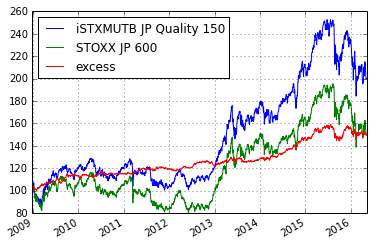

In [96]:
dfch.plot()

In [95]:
dfch['excess']=dfch['iSTXMUTB JP Quality 150'] - dfch['STOXX JP 600'] +100
dfch.head(3)

,iSTXMUTB JP Quality 150,STOXX JP 600,excess
2008-12-22,100.000000,100.000000,100.000000
2008-12-23,100.000000,100.000000,100.000000
2008-12-24,97.537639,97.467415,100.070223


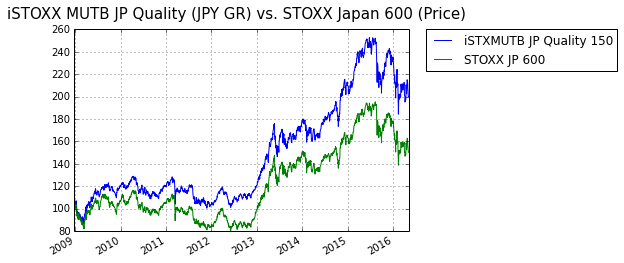

In [97]:
#chart compare
#dfch = dff[[3,2,9,6]]
#dfch = dff[[3,9,6]]
dfch = dft[[0,4,1]]
dfch.index = dfch['Date']
dfch.index.name = None
del dfch['Date']
dfch = dfch.fillna(method='pad')
#dfch.columns = ['iSTXMUTB JP Proactive Leaders 200', 'iSTXMUTB JP Quality 150', 'STOXX JP 600']
dfch.columns = ['iSTXMUTB JP Quality 150', 'STOXX JP 600']
dfch.plot()
#plt.suptitle('iSTOXX MUTB JP Proactive Leaders (JPY GR) vs. iSTOXX MUTB JP Quality (JPY GR) vs. STOXX Japan 600 (Price)', fontsize=15)
plt.suptitle('iSTOXX MUTB JP Quality (JPY GR) vs. STOXX Japan 600 (Price)', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [64]:
df = pd.read_csv(calcloc + '06_jp_proactive_wgts.csv', sep=';').sort(['date','isin'], ascending=[True, True])
df.tail()

,date,isin,curr,fx,sedol,icb,ffmcap_eur,ffmcap_jpy,name_,symbol,ICB_ind,ICB_sec,ICB_ind_name,ROE,final_score,rkFinal,wgt,cap,capfactor,cappedwgt
3138,2015-12-21,JP3974450003,JPY,0.007589,6044132,5753,2172839475,2.863294e+11,"RESORTTRUST,INC.",604413,5000,5750,Consumer Services,0.104945,0.555510,191,0.001473,0.02,1,0.001702
3069,2015-12-21,JP3976300008,JPY,0.007589,6758455,5373,5093453757,6.711981e+11,"RYOHIN KEIKAKU CO.,LTD.",675845,5000,5370,Consumer Services,0.147295,0.736138,19,0.003452,0.02,1,0.003989
3098,2015-12-21,JP3977400005,JPY,0.007589,6740582,3722,3385054711,4.460710e+11,RINNAI CORPORATION,674058,3000,3720,Consumer Goods,0.087086,0.725674,23,0.002294,0.02,1,0.002651
3071,2015-12-21,JP3982100004,JPY,0.007589,6266914,5337,4906956195,6.466221e+11,"Lawson,Inc.",626691,5000,5330,Consumer Services,0.115123,0.577736,163,0.003326,0.02,1,0.003843
3077,2015-12-21,JP3982800009,JPY,0.007589,6747204,9576,4682334775,6.170222e+11,ROHM COMPANY LIMITED,674720,9000,9570,Technology,0.068407,0.608016,126,0.003173,0.02,1,0.003667


In [87]:
#liquidity
locpac = bojloc + '04 PID PIC PAC/01 Numbers/'
df = pd.read_csv(calcloc + '05_jp_proactive_sel_list.csv', sep=';').sort(['date','isin'], ascending=[True, True])
dfw = pd.read_csv(calcloc + '06_jp_proactive_wgts.csv', sep=';').sort(['date','isin'], ascending=[True, True])
dfw = dfw[['date', 'isin','cappedwgt']]
df = df[df.date=='2015-12-21']
df['adtv_EUR'] = df.adtv * df.fx
df = pd.merge(df[['date','isin', 'name', 'adtv_EUR']], dfw, how='left', on=['date','isin']).sort('cappedwgt', ascending=False)
df['100mioEUR_Portfolio'] = (df.cappedwgt * 100000000) / df.adtv_EUR
df['500mioEUR_Portfolio'] = (df.cappedwgt * 500000000) / df.adtv_EUR
df['1bnEUR_Portfolio'] = (df.cappedwgt * 1000000000) / df.adtv_EUR
df = df.sort('100mioEUR_Portfolio', ascending=False)
df.to_csv(locpac +'/ADTV_analysis.csv',sep=';',index=False)
df[[1,2,3,4,5,6,7]].head(10)

,isin,name,adtv_EUR,cappedwgt,100mioEUR_Portfolio,500mioEUR_Portfolio,1bnEUR_Portfolio
349,JP3634600005,Toyota Industries Corp.,27614761.955936,0.008430,0.030528,0.152641,0.305282
334,JP3600200004,Toho Gas Co. Ltd.,8187413.210492,0.002342,0.028601,0.143003,0.286005
333,JP3598600009,Toho Co. Ltd. (9602),9567363.656625,0.002735,0.028591,0.142957,0.285915
114,JP3247090008,KYORIN HOLDINGS INC.,3459292.262438,0.000968,0.027970,0.139848,0.279696
135,JP3274400005,Glory Ltd.,5379440.865252,0.001475,0.027412,0.137062,0.274124
440,JP3784600003,Hisamitsu Pharmaceutical Co. I,9409098.966224,0.002576,0.027380,0.136898,0.273796
527,JP3910660004,Tokio Marine Holdings Inc.,74404013.585541,0.020000,0.026880,0.134401,0.268803
103,JP3229400001,Kansai Paint Co. Ltd.,11244978.609824,0.002928,0.026036,0.130179,0.260359
201,JP3371200001,Shin-Etsu Chemical Co. Ltd.,62991022.651443,0.016055,0.025488,0.127442,0.254884
86,JP3205800000,Kao Corp.,72426509.006276,0.018086,0.024971,0.124855,0.249710


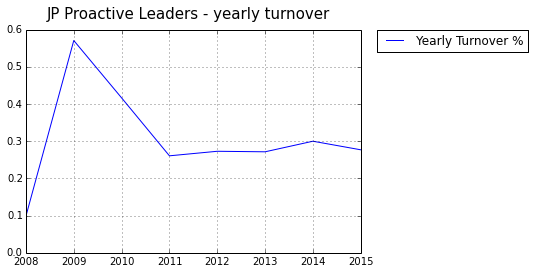

In [123]:
#turnover
locpac = bojloc + '04 PID PIC PAC/01 Numbers/'
df_ = pd.read_csv(loc_if + 'IndexReport_RuleModeler_iSTOXX MUTB Japan Proactive Leaders 200 (Price) - public.csv', sep=';')
#df_ = df_[df_.Date=='2016-04-29']

import stoxx.stats.turnover as to

t1=to.calc_turnover_df(df_, 'q')

t1 = t1.iloc[32:len(t1)-1,:]
t1[t1.month.isin([12,6])].to_excel(locpac +'turnover_analysis.xlsx', index=False)
t1['year'] = t1['year'].map(lambda x: str(x))
x = pd.DataFrame(t1.groupby(['year']).sum()['turnover'][:]) #groupby(['year','month'])
x.index.name = None
x.columns = ['Yearly Turnover %']
x.plot()
plt.suptitle('JP Proactive Leaders - yearly turnover', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

done


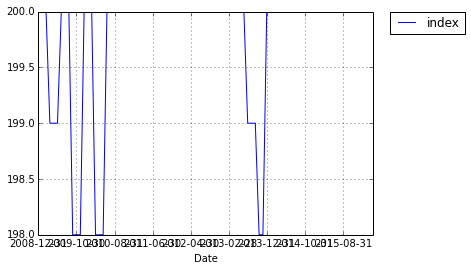

In [125]:
#compositions last day of the month
df1 = pd.read_csv(loc_if + 'IndexReport_RuleModeler_iSTOXX MUTB Japan Proactive Leaders 200 (Price) - public.csv', sep=';')

df1['dt']=pd.to_datetime(df1['Date'], format='%Y-%m-%d', dayfirst=True)
df1 = df1[df1.Date>='2008-12-01']
dts = pd.DatetimeIndex(df1['dt'].drop_duplicates())
dflastday = myf.monthend(dts)
df1 = df1[[1,3,14,30]]
df1 = pd.merge(dflastday, df1, left_on=dflastday.columns[0], right_on=df1.dt)
del df1[df1.columns[0]]
df1 = df1[[0,1,2]].sort(['Date','Weight in %'], ascending=[True, False]).reset_index(drop=True)
df1.to_excel(locpac + 'istoxx-mutb_jp_proactive_leaders_compositions_EOM.xlsx', index=False)

#component count stats
dfct = pd.DataFrame()
compct = pd.DataFrame(df1.groupby('Date').count()['ISIN'])
compct.columns = ['index']
dfct = pd.concat([dfct, compct], axis=1)
    
print('done')
dfct.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [123]:
#components
ben = 'TW1L'
locdata = 'Y:/STOXX/'
f = 'open_' + ben.lower() + '_20160429.csv'
dfbm = pd.read_csv(locdata + ben + '/' + f, sep=';', encoding='iso-8859-1')
dfbm = dfbm[['ISIN','Instrument_Name', 'Country', 'ICB']]

df_ = pd.read_csv(loc_if + 'IndexReport_RuleModeler_iSTOXX MUTB Japan Proactive Leaders 200 (Price) - public.csv', sep=';')
df_ = df_[df_.Date=='2016-04-29']
#df_[['Date','ISIN', 'ICB Supersector', 'ICB Sector', 'Weight in %']].sort('Weight in %', ascending=False)

df = pd.merge(df_[['Date','ISIN','Weight in %']], dfbm, how='left', on='ISIN').sort('Weight in %', ascending=False)
df[[0,1,3,4,2]].to_excel(histloc + '03 results/iSTOXX-MUTB_jp_proactive_leaders_200-composition_20160429.xlsx', index=False)

In [86]:
#PAC data
locpac = bojloc + '04 PID PIC PAC/01 Numbers/'
dfstats = dff[[3,0,1,2,4,5,6,7,8,9]]


#dff[[3,2,6,9]].to_csv(locpac + 'ts.csv', sep=';', index=False)
print('done')

#stats = myf.calc_stats_sharpe_ext(dfstats[[0,1,2,3]], rfrate=True) #proactive
stats = myf.calc_stats_sharpe_ext(dfstats[[0,4,5,6]], rfrate=True) # JP 600
#stats = myf.calc_stats_sharpe_ext(dfstats[[0,7,8,9]], rfrate=True) #Quality
stats.iloc[:,:-1] = np.around(stats.iloc[:,:-1].astype(np.double), decimals=4)
stats

done


SX60JJP  SX60JJN  SX60JJG            period
return actual         0   0.5520   0.7298   0.7592  as of 2008-12-22
                      1   0.5574   0.6795   0.7017                5y
                      2   0.1548   0.2005   0.2113                3y
                      3  -0.1776  -0.1665  -0.1636                1y
                      4  -0.1310  -0.1251  -0.1236               YTD
                      5  -0.0257  -0.0256  -0.0257                1m
return ann.           0   0.0592   0.0743   0.0767  as of 2008-12-22
                      1   0.0889   0.1048   0.1076                5y
                      2   0.0471   0.0602   0.0633                3y
                      3  -0.1708  -0.1600  -0.1573                1y
                      4  -0.3382  -0.3250  -0.3217               YTD
                      5  -0.2463  -0.2460  -0.2466                1m
volatility ann.       0   0.2074   0.2075   0.2075  as of 2008-12-22
                      1   0.2036   0.2037   0.2037                5y
                      2   0.2205   0.2207   0.2208                3y
                      3   0.2628   0.2631   0.2633                1y
                      4   0.3396   0.3409   0.3413               YTD
                      5   0.2944   0.2945   0.2945                1m
dividend yield ann.   0      NaN   0.0151   0.0175  as of 2008-12-22
                      1      NaN   0.0159   0.0187                5y
                      2      NaN   0.0131   0.0161                3y
                      3      NaN   0.0108   0.0135                1y
                      4      NaN   0.0132   0.0166               YTD
                      5      NaN   0.0003  -0.0003                1m
Sharpe ratio EUR ann. 0   0.3668   0.4352   0.4457  as of 2008-12-22
                      1   0.4974   0.5687   0.5809                5y
                      2   0.3155   0.3718   0.3848                3y
                      3  -0.4990  -0.4487  -0.4357                1y
                      4  -0.8380  -0.7750  -0.7588               YTD
                      5  -0.2399  -0.2396  -0.2412                1m
max drawdown          0   0.3084   0.2904   0.2889  as of 2008-12-22
                      1   0.2894   0.2851   0.2840                5y
                      2   0.2894   0.2851   0.2840                3y
                      3   0.2894   0.2851   0.2840                1y
                      4   0.2029   0.2028   0.2028               YTD
                      5   0.0636   0.0635   0.0636                1m

In [24]:
#sector country allocation - production methodology

ben = 'SX60JJP' #benchamrk: 'SXW1E','SXWNJP','SXWNAP'

dff = pd.read_csv(calcloc + '06_jp_proactive_wgts.csv', sep=';')
dff = dff[dff.date=='2015-12-21'].sort('ffmcap_jpy', ascending=False)
dff.groupby('ICB_ind_name').sum()['cappedwgt']
#dff.groupby('country').sum()['cappedwgt']

#get benchmark data
locdata = 'Y:/STOXX/'
f = 'open_' + ben.lower() + '_20151221.csv'
dfbm = pd.read_csv(locdata + ben + '/' + f, sep=';', encoding='iso-8859-1')
dfbm = dfbm[['Instrument_Name', 'Country', 'Currency', 'ICB', 'FX_local_to_Index_Currency', 'Mcap_Units_Index_Currency', 'Weight']]
#print(locdata + ben + '/' + f)
pd.DataFrame(dff.groupby('ICB_sec').sum()['cappedwgt']).sort()
#pd.DataFrame(dfbm.groupby('ICB').sum()['Weight'])
#pd.DataFrame(dff.groupby('country').sum()['cappedwgt']).sort('cappedwgt', ascending=True)

,cappedwgt
ICB_sec,
1350,0.059887
1750,0.006328
2350,0.010485
2720,0.003055
2730,0.093171
2750,0.120151
2790,0.035563
3350,0.160317
3530,0.010524


In [10]:
pd.read_csv(calcloc + '06_jp_proactive_wgts.csv', sep=';').head(1)

,date,isin,curr,fx,sedol,icb,ffmcap_eur,ffmcap_jpy,name_,symbol,ICB_ind,ICB_sec,ICB_ind_name,ROE,final_score,rkFinal,wgt,cap,capfactor,cappedwgt
0,2008-06-23,JP3633400001,JPY,0.005983,6900643,3353,1.111303e+11,1.857291e+13,TOYOTA MOTOR CORPORATION,NaN,3000,3350,Consumer Goods,0.14473,0.570132,182,0.092525,0.02,0.172179,0.02


In [6]:
loc_if = histloc + '02 index factory/01 histories/'
df_ = pd.read_csv(loc_if + 'IndexReport_RuleModeler_iSTOXX MUTB Japan Proactive Leaders 200 (Price) - public.csv', sep=';')
#df_ = df_[(df_.Date>='2011-04-21') & (df_.Date<='2011-04-26')]
df_.columns
print(len(df_))
df_['Weight in %'].max()

407802


C:\Users\txg2a\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas-0.16.0-py3.4-win-amd64.egg\pandas\io\parsers.py:1164: DtypeWarning: Columns (2,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


4.1010609861870098

In [99]:
df_.columns

Index(['Listing ID', 'Date', 'Name', 'ISIN', 'RIC', 'Exchange', 'Code', 'Currency', 'Price (local)', 'F/X rate', 'Price (Euro)', 'Open (Euro)', 'Correction factor (CI)', 'Weight factor (QI)', 'Weight in %', 'Primary RIC', 'SEDOL', 'Instrument ID', 'Organisation ID', 'ICB Industry', 'ICB Supersector', 'ICB Sector', 'ICB Subsector', 'Industry Group (Reuters)', 'Industry (Reuters)', 'ADTV (3 Months)', 'Country', 'Freefloat Market Cap', 'Freefloat Shares', 'Full Market Cap'], dtype='object')

In [7]:
df_ = df_[['Date','ISIN','SEDOL','Price (local)','F/X rate','Price (Euro)','Correction factor (CI)','Weight factor (QI)']]
#df_.to_csv(loc_if + 'index_easter2011.csv', sep=';', index=False)
df_['mcap'] = df_['Price (local)'] * df_['Correction factor (CI)'] * df_['Weight factor (QI)'] *  df_['F/X rate']

In [136]:
dfa = df_[df_.Date=='2011-04-21']
dfb = df_[df_.Date=='2011-04-26']

In [137]:
x = pd.merge(dfa, dfb, how='outer', on='ISIN')
x.to_csv(loc_if + 'index_ret_easter.csv', sep=';', index=False)

In [169]:
x = q.get_curr_rate('EUR', 'JPY', '2011-04-20', '2011-04-26')
#x.to_csv(loc + 'python/exrates.csv', index=True, sep=';')
x
28. April 2016 06:20

,curr1,curr2,value_
2011-04-20,EUR,JPY,119.64629
2011-04-21,EUR,JPY,119.09929
2011-04-25,EUR,JPY,119.29729
2011-04-26,EUR,JPY,119.50179


In [37]:
df[(df.index>='2011-04-21') & (df.index<='2011-04-26')][[0,3,6]]

,ISXMPLP,ISXMPLN,ISXMPLG
2011-04-21,122.281509,128.141138,128.542601
2011-04-26,120.444882,126.216501,126.611934


In [170]:
y = df_[(df_.Date=='2011-04-21') | (df_.Date=='2011-04-26')]
y.groupby('Date').sum()

,Price (local),F/X rate,Price (Euro),Correction factor (CI),Weight factor (QI),mcap
Date,,,,,,
2011-04-21,4901017,1.67926,41150.440757,702.407292,87740737.542996,8.912334e+08
2011-04-26,4948520,1.67362,41409.697115,702.407292,87740737.542996,8.778474e+08


In [45]:
#divisors
div1 = 8.912334e+08 / 92.7234625435792
div2 = 8.778474e+08 / 91.3307873077603
print('div Price', div1, div2, ' -- ', (div1+div2)/2)

div1 = 8.912334e+08 / 98.0171664300757
div2 = 8.778474e+08 / 96.5449815415082
print('div Net', div1, div2, ' -- ', (div1+div2)/2)

div1 = 8.912334e+08 / 98.3288961491549
div2 = 8.778474e+08 / 96.8520291850035
print('div Gross', div1, div2, ' -- ', (div1+div2)/2)

div Price 9611735.536527535 9611735.821808798  --  9611735.679168167
div Net 9092625.633447539 9092625.90332136  --  9092625.76838445
div Gross 9063799.502519483 9063799.771537727  --  9063799.637028605


In [8]:
df22 = df_[(df_.Date=='2011-04-21')][[0,1,2,4,6,7]]
df22.Date = '2011-04-22'
df22['local_pr'] = 0
for index, row in df22.iterrows():
    if isnan(q.get_infocode(row.SEDOL)):
        df22.loc[index,'local_pr'] = q.get_localclose(row.ISIN, '2011-04-22')
    else:
        df22.loc[index,'local_pr'] = q.get_localclose(str(row.SEDOL), '2011-04-22')

df25 = df_[(df_.Date=='2011-04-21')][[0,1,2,4,6,7]]
df25.Date = '2011-04-25'
df25['local_pr'] = 0
for index, row in df25.iterrows():
    if isnan(q.get_infocode(row.SEDOL)):
        df25.loc[index,'local_pr'] = q.get_localclose(row.ISIN, '2011-04-25')
    else:
        df25.loc[index,'local_pr'] = q.get_localclose(str(row.SEDOL), '2011-04-25')
        
df25.head(1)

,Date,ISIN,SEDOL,F/X rate,Correction factor (CI),Weight factor (QI),local_pr
146745,2011-04-25,JP3675600005,6641760,0.008396,1,92531.436916,2842


In [16]:
df22['mcap'] = df22['F/X rate'] * df22['Correction factor (CI)'] * df22['Weight factor (QI)'] * df22['local_pr']
df22.groupby('Date').sum()

,F/X rate,Correction factor (CI),Weight factor (QI),local_pr,mcap
Date,,,,,
2011-04-22,1.67926,702.407292,87740737.542996,4918264,8.900911e+08


In [24]:
df25['mcap'] = df25['F/X rate'] * df25['Correction factor (CI)'] * df25['Weight factor (QI)'] * df25['local_pr']
df25.groupby('Date').sum()

,F/X rate,Correction factor (CI),Weight factor (QI),local_pr,mcap
Date,,,,,
2011-04-25,1.67926,702.407292,87740737.542996,4934503,8.872488e+08


In [46]:
index22 = 8.900911e+08 / 9611735.679
index25 = 8.872488e+08 / 9611735.679
print('price' , index22, index25)

index22 = 8.900911e+08 / 9092625.76838445
index25 = 8.872488e+08 / 9092625.76838445
print('net', index22, index25)

index22 = 8.900911e+08 / 9063799.637028605
index25 = 8.872488e+08 / 9063799.637028605
print('gross', index22, index25)

price 92.60461686901118 92.30890544966681
net 97.89153569862017 97.57894172715345
gross 98.20286586694667 97.88927773461548


In [93]:
z = pd.read_csv(loc_if + '18724 RuleModeler_iSTOXX MUTB Japan Proactive Leaders 200 (Price) - public EUR.csv', sep=';')
df100 = pd.DataFrame(data={z.columns[0]:['2011-04-22','2011-04-25'], z.columns[1]: [92.60461686901118,92.30890544966681]})
df100 = df100[[1,0]]
z = pd.concat([z, df100], axis=0).sort(z.columns[0])
z.to_csv(loc_if + '18724 RuleModeler_iSTOXX MUTB Japan Proactive Leaders 200 (Price) - public EUR.csv', sep=';', index=False)

zz = pd.read_csv(loc_if + '18725 RuleModeler_iSTOXX MUTB Japan Proactive Leaders 200 (Net Return) - public EUR.csv', sep=';')
df100 = pd.DataFrame(data={zz.columns[0]:['2011-04-22','2011-04-25'], zz.columns[1]: [97.89153569862017,97.57894172715345]})
df100 = df100[[1,0]]
zz = pd.concat([zz, df100], axis=0).sort(zz.columns[0])
zz.to_csv(loc_if + '18725 RuleModeler_iSTOXX MUTB Japan Proactive Leaders 200 (Net Return) - public EUR.csv', sep=';', index=False)

zzz = pd.read_csv(loc_if + '18726 RuleModeler_iSTOXX MUTB Japan Proactive Leaders 200 (Gross Return) - public EUR.csv', sep=';')
df100 = pd.DataFrame(data={zzz.columns[0]:['2011-04-22','2011-04-25'], zzz.columns[1]: [98.20286586694667,97.88927773461548]})
df100 = df100[[1,0]]
zzz = pd.concat([zzz, df100], axis=0).sort(zzz.columns[0])
zzz.to_csv(loc_if + '18726 RuleModeler_iSTOXX MUTB Japan Proactive Leaders 200 (Gross Return) - public EUR.csv', sep=';', index=False)

In [35]:
df[(df.index>='2011-04-21') & (df.index<='2011-04-26')][[0,3,6]]

,ISXMPLP,ISXMPLN,ISXMPLG
2011-04-21,122.281509,128.141138,128.542601
2011-04-26,120.444882,126.216501,126.611934


In [86]:
df[df.index>'2011-04-20'].head()

,ISXMPLP,ISXMPLL,ISXMPLYP,ISXMPLN,ISXMPLV,ISXMPLYN,ISXMPLG,ISXMPLU,ISXMPLYG
2011-04-21,92.723463,135.102665,11043.298555,98.017166,142.815854,11673.774930,98.328896,143.270059,11710.901718
2011-04-22,92.604617,134.929501,11029.144120,97.891536,142.632803,11658.812399,98.202866,143.086427,11695.891601
2011-04-25,92.308905,134.401711,11012.202263,97.578942,142.074881,11640.903309,97.889278,142.526730,11677.925554
2011-04-26,91.330787,133.580391,10914.192565,96.544982,141.206671,11537.298110,96.852029,141.655759,11573.990853
2011-04-27,91.056458,133.324784,11027.300375,96.254990,140.936470,11656.863393,96.561116,141.384699,11693.936396


In [61]:
df100 = pd.DataFrame(data={0:['2011-04-22','2011-04-25'], 1: [92.60461686901118,92.30890544966681]})
#z
df100

,0,1
0,2011-04-22,92.604617
1,2011-04-25,92.308905


In [29]:
122.124778239642/122.281509 - 1

-0.0012817208557509563

In [30]:
120.444882 / 121.73480101462516 - 1

-0.010596140165951229

In [32]:
9682.21/9685.77 - 1

-0.0003675495081961744

In [34]:
9671.96/9682.21 - 1


-0.0010586426032899166

In [4]:
def get_wsfields_last_reported_table(sedol, codes, isocode):
    sqlstr = """
    select a.code, a.item, a.freq, a.year_, a.seq, a.epsReportDate as date_, a.value_, a.itemUnits as isocode from [vw_WSItemData] a
    JOIN Wsinfo u on u.Code = a.Code
    where u.Sedol = '%s'
    and Item in (%s)
    and a.freq in ('S','A','Q','R')
    and itemUnits = '%s'
    order by epsReportDate desc, year_ desc
    """ % (str(sedol)[0:6], codes, isocode)
    try:
        res= pd.io.sql.read_sql(sqlstr,con)
        return res
    except:
        return np.nan

In [7]:
-4912000000-1505000000-21714000000+49155000000

21024000000

In [5]:
get_wsfields_last_reported_table('6366007','1551','JPY')

,code,item,freq,year_,seq,date_,value_,isocode
0,16507,1551,Q,2016,1,2016-05-13,-4912000000,JPY
1,16507,1551,Q,2015,4,2016-02-12,-1505000000,JPY
2,16507,1551,A,2015,1,2016-02-12,51000000,JPY
3,16507,1551,Q,2015,3,2015-11-13,-21714000000,JPY
4,16507,1551,R,2015,3,2015-11-13,1556000000,JPY
5,16507,1551,R,2015,2,2015-08-14,23270000000,JPY
6,16507,1551,Q,2015,2,2015-08-14,49155000000,JPY
7,16507,1551,Q,2015,1,2015-05-15,-25885000000,JPY
8,16507,1551,Q,2014,4,2015-02-13,-5008000000,JPY
9,16507,1551,A,2014,1,2015-02-13,-13975000000,JPY


In [9]:
-3227000000+2916000000+8806000000

8495000000

In [19]:
df = get_wsfields_last_reported_table('6805469',1551,'JPY')


In [22]:
dto=dt.datetime.strptime('2016-05-31', '%Y-%m-%d')
get_ws_agg(df, 1551, dto)

9155000000.0

In [21]:
def get_ws_agg(df, item_, d):
    df1 = df[(df.item==item_) & (df.date_<=d)]
    if len(df1)>0:
        
        dfcond = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='S')] #needed for case S1
        if len(df1[(df1['date_']>=myf.add_months(d,-1)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-1)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_'] #in there's an A in the last 3 months
            x = 'A4'

        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')])==4:
            val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')].sum()['value_']
            x = 'Q12'

        elif len(df1[(df1['date_']>=myf.add_months(d,-6)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-6)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A6'

        elif len(df1[(df1['date_']>=myf.add_months(d,-7)) & (df1['freq']=='S') & (df1['seq']==2)])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-7)) & (df1['freq']=='S') & (df1['seq']==2)].reset_index(drop=True).loc[0,'value_']
            x = 'S2'

        elif len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)])>=3:
            if df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True).loc[0,'seq']==4:
                val = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True).loc[0,'value_']
                x = 'R4'
            else:
                df0=df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='R') & -(df1['seq']==1) & -(df1['seq']==3)].reset_index(drop=True)
                val = df0.loc[0,'value_'] + df0.loc[1,'value_'] - df0.loc[2,'value_']
                x = 'R2'

        elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A9'
            
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1.freq=='A')])==1:
            anval = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1.freq=='A')].reset_index(drop=True).loc[0,'value_']
            if len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==3)])==2:
                dfR = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==3)].reset_index(drop=True).sort(['date_','year_'], ascending=[False, False])
                val = dfR.loc[0,'value_'] - dfR.loc[1,'value_'] + anval
                x = 'AR3'

            elif len(df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==2)])==2:
                dfR = df1[(df1['date_']>=myf.add_months(d,-18)) & (df1.freq=='R') & (df1.seq==2)].reset_index(drop=True).sort(['date_','year_'], ascending=[False, False])
                val = dfR.loc[0,'value_'] - dfR.loc[1,'value_'] + anval
                x = 'AR2'
            else:
                val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
                x = 'A12'
                
        elif  (len(dfcond)>2):
            if (dfcond.reset_index(drop=True).loc[0,'seq']==1): 
                df0=df1[(df1['date_']>=myf.add_months(d,-18)) & (df1['freq']=='S')].reset_index(drop=True)
                val = df0.loc[0,'value_'] + df0.loc[1,'value_'] - df0.loc[2,'value_'] 
                x = 'S1'
            else:
                val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
                x = 'A12'
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')])>0:
            val = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            x = 'A12'
        else:
            val = 0
            x = '-'
    
    else:
        val = np.nan
    
    return val

In [33]:
def get_net_income(sedol, d, isocode, df):

    #Net Income Before Extraordinary Items/Preferred Dividends
    df1 = df[(df.item==1551) & (df.date_<=d)] 
    if len(df1)>0:
        
        df0=df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq'].isin(list(('S','A'))))]
        if len(df1[(df1['date_']>=myf.add_months(d,-1)) & (df1['freq']=='A')])>0:
            net_i_bef = df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_'] 
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')])==4:
            net_i_bef = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')].sum()['value_']
        elif (len(df0)>=3) & (len(df0[df0['freq']=='S'])>1) & (len(df0[df0['freq']=='A'])>=1) & (len(df0[(df0['freq']=='S') & (df0['seq']==2)])==1):
            a1=df0[df0['freq']=='A'].reset_index(drop=True).loc[0,'value_']
            s2=df0[(df0['freq']=='S') & (df0['seq']==2)].reset_index(drop=True).loc[0,'value_']
            if a1!=s2:
                net_i_bef = df0[df0['freq']=='S'].sum()['value_']
            elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
                net_i_bef = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            else:
                net_i_bef = 0
        elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
            net_i_bef = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
        else:
            net_i_bef = 0
    else:
        net_i_bef = 0
    
    #Discontinued Operation
    df1 = df[(df.item==1505) & (df.date_<=d)] 
    if len(df1)>0:

        df0=df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq'].isin(list(('S','A'))))]
        if len(df1[(df1['date_']>=myf.add_months(d,-1)) & (df1['freq']=='A')])>0:
            disc_ops = df1[(df1['date_']>=myf.add_months(d,-4)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
        elif len(df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')])==4:
            disc_ops = df1[(df1['date_']>=myf.add_months(d,-12)) & (df1['freq']=='Q')].sum()['value_']
        elif (len(df0)>=3) & (len(df0[df0['freq']=='S'])>1) & (len(df0[df0['freq']=='A'])>=1) & (len(df0[(df0['freq']=='S') & (df0['seq']==2)])==1):
            a1=df0[df0['freq']=='A'].reset_index(drop=True).loc[0,'value_']
            s2=df0[(df0['freq']=='S') & (df0['seq']==2)].reset_index(drop=True).loc[0,'value_']
            if a1!=s2:
                disc_ops = df0[df0['freq']=='S'].sum()['value_']
            elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
                disc_ops = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
            else:
                disc_ops = 0
        elif len(df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')])>0:
            disc_ops = df1[(df1['date_']>=myf.add_months(d,-9)) & (df1['freq']=='A')].reset_index(drop=True).loc[0,'value_']
        else:
            disc_ops = 0
    else:
        disc_ops = 0    
    
    return float(net_i_bef)-float(disc_ops)

In [34]:
x =get_net_income('6805469', dto,'JPY', df)
#df = get_wsfields_last_reported_table('6805469',1551,'JPY')
x

9155000000.0

In [29]:
a=1
a

1

In [31]:
dto

datetime.datetime(2016, 5, 31, 0, 0)